# Language Changes

Group 5

- Alexander Bek, 
- Evelyn Birnzain,
- Eszter Iklódi,
- Anton Wohlgemuth

#### General questions of the task

- How does the use of various communication languages in countries change over time? 
- Which languages grow and which disappear, and what are their characteristics? 
- Are there other factors that correlate with the appearance or disappearance of languages?

#### Challenges of the task

- How to define extinction for languages? No native users? No one understands at all? 
- The ultimate historical data on language use of Ethnologue is way too expensive for a university project.
- There's a bias that there's more data for frequently used languages.

#### Restrictions

- Use only European data.
- Use data earliest from 1980s.

In [34]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import explained_variance_score

import os                       
import re # regular expression
import glob
from collections import Counter
_ = !pip install pyreadstat

from sklearn import svm
from sklearn import neighbors
from sklearn import tree
from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier

PATH_DATA = r'data/' 
INTERACTIVE = False
if INTERACTIVE:
    %matplotlib notebook
else:
    %matplotlib inline 
    
eb_dir = PATH_DATA + 'eurobarometer/'
pop_dir = PATH_DATA + 'population/'
in_dir = eb_dir + "raw_data/"

step1_dir = eb_dir + "step1/"
os.makedirs(step1_dir, exist_ok=True)

step2_dir = eb_dir + "step2/"
os.makedirs(step2_dir, exist_ok=True)

## Explore: Look into endangered languages data

(Eszter Iklódi)

#### Endangered languages

- https://www.kaggle.com/the-guardian/extinct-languages/version/1 (updated in 2016)
- original data: http://www.unesco.org/languages-atlas/index.php?hl=en&page=atlasmap (published in 2010)

#### Countries of the world

- https://www.ethnologue.com/sites/default/files/CountryCodes.tab

Detailed processing: https://github.com/Eszti/lang-changes/blob/main/notebooks/Eszti/unesco_endangered_lang_europe.ipynb

#### First let's plot the distribution!

In [2]:
# https://www.kaggle.com/the-guardian/extinct-languages/version/1
df_end = pd.read_csv("data/endangerment/extinct_languages.csv")
df_end.head()

,ID,Name in English,Name in French,Name in Spanish,Countries,Country codes alpha 3,ISO639-3 codes,Degree of endangerment,Alternate names,Name in the language,Number of speakers,Sources,Latitude,Longitude,Description of the location
0,1022,South Italian,italien du sud,napolitano-calabrés,Italy,ITA,nap,Vulnerable,Neapolitan; Neapolitan-Calabrese; неаполитанск...,NaN,7500000.0,NaN,40.9798,15.2490,"Campania, Lucania (Basilicata), Abruzzi (Abruz..."
1,1023,Sicilian,sicilien,siciliano,Italy,ITA,scn,Vulnerable,NaN,NaN,5000000.0,NaN,37.4399,14.5019,"Sicily (Sicilia), southern and central Calabri..."
2,383,Low Saxon,bas-saxon,bajo sajón,"Germany, Denmark, Netherlands, Poland, Russian...","DEU, DNK, NLD, POL, RUS","act, drt, frs, gos, nds, sdz, stl, twd, vel, wep",Vulnerable,"Low German, Niedersächsisch, Nedersaksisch, Ni...",Neddersassisch,4800000.0,NaN,53.4029,10.3601,"northern Germany, the north-eastern part of th..."
3,335,Belarusian,biélorusse,bielorruso,"Belarus, Latvia, Lithuania, Poland, Russian Fe...","BRB, LVA, LTU, POL, RUS, UKR",bel,Vulnerable,NaN,NaN,4000000.0,Hienadź Cychun: Weißrussisch. — Lexikon der Sp...,53.9560,27.5756,Belarus except the Polesian-speaking south-wes...
4,382,Lombard,lombard,lombardo,"Italy, Switzerland","ITA, CHE",lmo,Definitely endangered,NaN,NaN,3500000.0,NaN,45.7215,9.3273,the region of Lombardy (except the southernmos...


<AxesSubplot:>

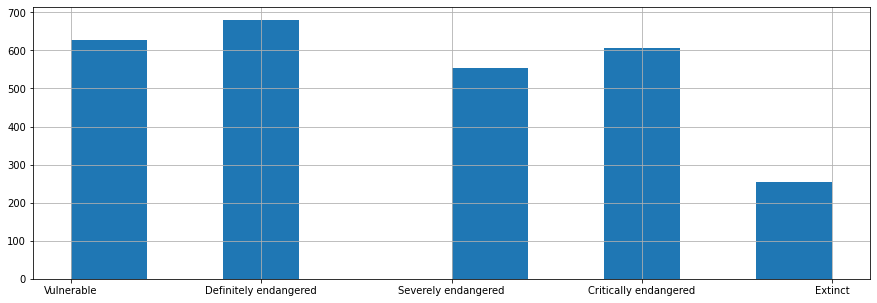

In [3]:
# Map textual degree of endangerment to numeric value
ENDANGERMENT_MAP = {
    "Vulnerable": 1,
    "Definitely endangered": 2,
    "Severely endangered": 3,
    "Critically endangered": 4,
    "Extinct": 5,
}
df_end["Endangerment code"] = df_end["Degree of endangerment"].apply(lambda x: ENDANGERMENT_MAP[x])
df_end["Degree of endangerment"].hist(figsize=(15,5))

#### Show languages on map

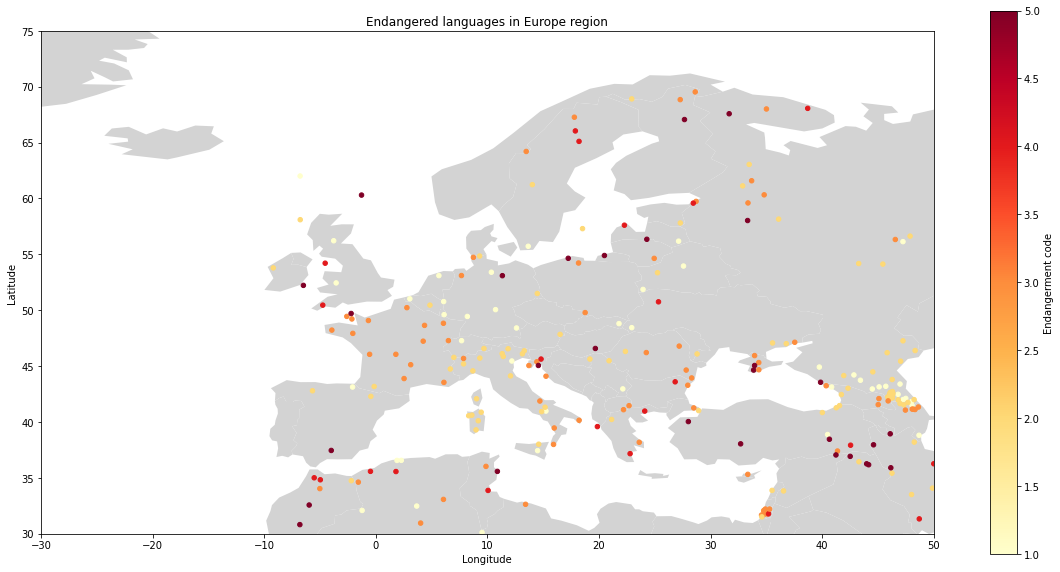

In [4]:
countries_map = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
fig, ax = plt.subplots(figsize=(20, 10))

# Plot Europe
countries_map.plot(color='lightgrey', ax=ax)
plt.xlim([-30, 50])
plt.ylim([30, 75])

df_end.plot(
    x="Longitude", 
    y="Latitude", 
    kind="scatter", 
    title="Endangered languages in Europe region", 
    c="Endangerment code", 
    colormap="YlOrRd",
    ax=ax,
)

plt.show()

#### Filter European languages

In [5]:
# https://www.ethnologue.com/sites/default/files/CountryCodes.tab
countries = pd.read_csv("data/general/country_codes.tsv", sep="\t")
europe = countries[countries["Area"] == "Europe"]
europe_countries = set(europe["Name"].to_list())

# Clean data
df_end = df_end[df_end["Countries"].notna()]

# Filter
df_end["In Europe"] = df_end["Countries"].apply(lambda x: len(europe_countries.intersection(set(x.split(",")))) > 0)
df_europe = df_end.loc[df_end["In Europe"] == True]

df_europe.head()

/tmp/ipykernel_213176/2900314512.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_end["In Europe"] = df_end["Countries"].apply(lambda x: len(europe_countries.intersection(set(x.split(",")))) > 0)


,ID,Name in English,Name in French,Name in Spanish,Countries,Country codes alpha 3,ISO639-3 codes,Degree of endangerment,Alternate names,Name in the language,Number of speakers,Sources,Latitude,Longitude,Description of the location,Endangerment code,In Europe
0,1022,South Italian,italien du sud,napolitano-calabrés,Italy,ITA,nap,Vulnerable,Neapolitan; Neapolitan-Calabrese; неаполитанск...,NaN,7500000.0,NaN,40.9798,15.2490,"Campania, Lucania (Basilicata), Abruzzi (Abruz...",1,True
1,1023,Sicilian,sicilien,siciliano,Italy,ITA,scn,Vulnerable,NaN,NaN,5000000.0,NaN,37.4399,14.5019,"Sicily (Sicilia), southern and central Calabri...",1,True
2,383,Low Saxon,bas-saxon,bajo sajón,"Germany, Denmark, Netherlands, Poland, Russian...","DEU, DNK, NLD, POL, RUS","act, drt, frs, gos, nds, sdz, stl, twd, vel, wep",Vulnerable,"Low German, Niedersächsisch, Nedersaksisch, Ni...",Neddersassisch,4800000.0,NaN,53.4029,10.3601,"northern Germany, the north-eastern part of th...",1,True
3,335,Belarusian,biélorusse,bielorruso,"Belarus, Latvia, Lithuania, Poland, Russian Fe...","BRB, LVA, LTU, POL, RUS, UKR",bel,Vulnerable,NaN,NaN,4000000.0,Hienadź Cychun: Weißrussisch. — Lexikon der Sp...,53.9560,27.5756,Belarus except the Polesian-speaking south-wes...,1,True
4,382,Lombard,lombard,lombardo,"Italy, Switzerland","ITA, CHE",lmo,Definitely endangered,NaN,NaN,3500000.0,NaN,45.7215,9.3273,the region of Lombardy (except the southernmos...,2,True


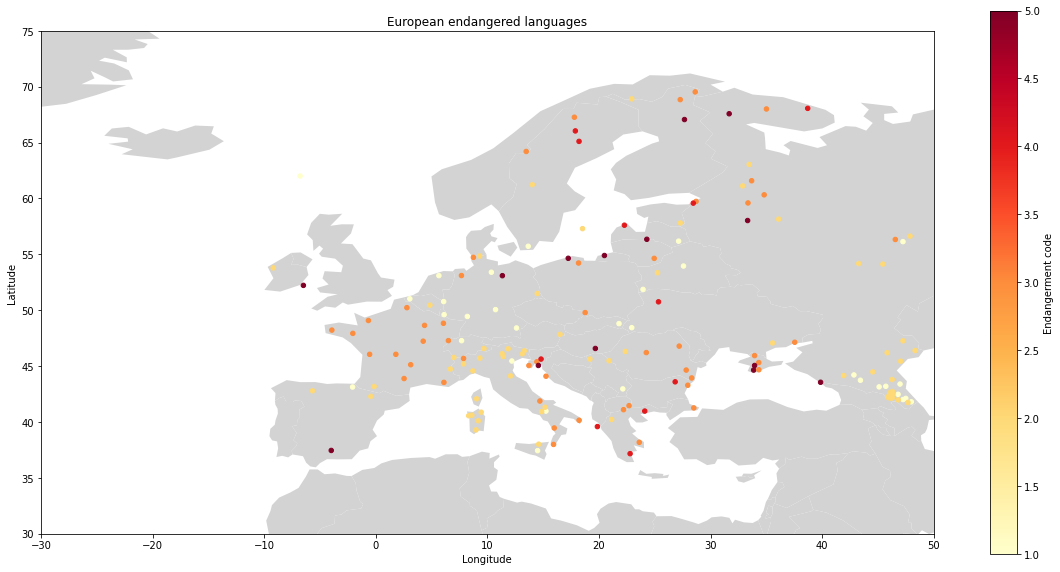

In [6]:
# Plot only European endangered languages
fig, ax = plt.subplots(figsize=(20, 10))

countries_map.plot(color='lightgrey', ax=ax)
plt.xlim([-30, 50])
plt.ylim([30, 75])

df_europe.plot(
    x="Longitude", 
    y="Latitude", 
    kind="scatter", 
    title="European endangered languages", 
    c="Endangerment code", 
    colormap="YlOrRd",
    ax=ax,
)

plt.show()

## Question 1: Which digital resources are the most important for the survival of a language?

(Eszter Iklódi)

### Data

#### Digital Language Death

Paper (2012): https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0077056  
Data: http://hlt.sztaki.hu/resources/  
Data description: http://hlt.sztaki.hu/resources/dld-header.pdf  
Online version: https://hlt.bme.hu/en/dld/  

#### Crúbadán project

DLD data uses the Crúbadán crawls. The aim of this project is the creation of text corpora for a large number of under-resourced languages by crawling the web. It supports more than 2000 languages.

Paper (2007): https://cs.slu.edu/~scannell/pub/wac3.pdf  
Project website: http://crubadan.org/

Detailed processing: https://github.com/Eszti/lang-changes/blob/main/notebooks/Eszti/dld_european_lang.ipynb

#### Prepare data

In [7]:
# http://hlt.sztaki.hu/resources/dld-joined.tsv
dld = pd.read_csv("data/digital/dld_joined.tsv", sep="\t", skiprows=2, low_memory=False)

LANG_ID = "LangID"

######################
# Columns of interest
######################

# Ids & Names
PRINT_NAME = "Print_Name" # standardized English language name
LANG_LOC = "language (local)" # the local name of the language
SIL = "SIL code" # SIL code

# Endangerment status
ETHN = "Eth_Language Status" # the EGIDS status of the language according to the Ethnologue.
ELP = "end_class" # classification according to the Endangered Languages Project (the higher, the more endangered)

# Speakers
L1 = "L1" # number of people speaking the language natively (L1 speakers)
L2 = "L2" # number of people speaking the language as second language (L2 speakers)

# Wikipedia
WP_NAME = "wikiname" # the two-letter (sometimes longer) code used in Wikipedia
WP_ART = "articles" # number of articles in wikipedia (2012 May)
WP_SIZE_ADJ = "adjusted WP size" # character count of ‘real’ wikipedia pages
WP_SIZE_CH = "WP size in chars" # raw (unadjusted) character count of wikipedia
WP_INCUB = "WP_incubator_new" # whether Wikipedia had an incubator for the language in March 2013
WP_AVG_LEN = "avg good page length" # average length of ‘real’ wikipedia pages
WP_REAL_TOT = "real/ total ratio" #  proportion of ‘real’ and 'total' wikipedia pages

# Windows
MS_IN = "MS-if-pack" # Microsoft input-level support
MS_OS = "MS-pack" # OS-level support in Windows 7

# MAC
MAC_IN = "MAC-input" # input-level support by Apple
MAC_OS = "MAC-supp" # OS-level support in MacOS 10.6.8

# Spellchecker
HUN_STAT = "hunspell status" # whether a hunspell checker exists
HUN_COV = "hunspell coverage" # the percentage coverage Hunspell has on the wikipedia dump

# Crúbadán
CR1_ID = "cru1_ISO-639-3" # iso-code from first Crúbadán summary
CR2_ID = "cru2_ISO-639-3" # iso-code from second Crúbadán summary

CR1_CH = "cru1_Characters" # number of characters found by the first Crúbadán crawl
CR2_CH = "cru2_Characters" # number of characters found by the second Crúbadán crawl

CR1_WORDS = "cru1_Words" # number of words found by the first Crúbadán crawl
CR2_WORDS = "cru2_Words" # number of words found by the second Crúbadán crawl

CR1_DOCS = "cru1_Docs" # number of documents found by the first Crúbadán crawl
CR2_DOCS = "cru2_Docs" # number of documents found by the second Crúbadán crawl

CR1_UDHR = "cru1_UDHR" # translation of the Universal Declaration of Human rights exists according to the first Crúbadán summary
CR2_UDHR = "cru2_UDHR" # translation of the Universal Declaration of Human rights exists according to the second Crúbadán summary

CR1_FLOSS = "cru1_FLOSS SplChk" # whether a FLOSS spellchecker exists according to the first Crúbadán summary
CR2_FLOSS = "cru2_FLOSS SplChk" # whether a FLOSS spellchecker exists according to the second Crúbadán summary

CR1_BIB = "cru1_WT" # whether an online Bible exists at watchtower.org according to the first Crúbadán summary
CR2_BIB = "cru2_WT" # whether an online Bible exists at watchtower.org according to the second Crúbadán summary

# Other
TLD = "TLDs(%)" # whether a national level Top Level Domain (not .com, .org, .edu) appeared in the top three domains that the crawl found language data in
OLAC = "la_Primary texts_Online" # the number of OLAC primary texts online

In [8]:
# Filter columns of interest

dld_fil = dld[[
    # Ids & names
    PRINT_NAME,
    LANG_LOC,
    SIL,    
    
    # Endangerment status
    ETHN,
    ELP,
    
    # Speakers
    L1,
    L2,
    
    # Wikipedia
    WP_NAME,
    WP_ART,
    WP_SIZE_ADJ,
    WP_SIZE_CH,
    WP_INCUB,
    WP_AVG_LEN,
    WP_REAL_TOT,
    
    # Windows
    MS_IN,
    MS_OS,
    
    # MAC
    MAC_IN,
    MAC_OS,
    
    # Spellchecker
    HUN_STAT,
    HUN_COV,
    
    # Crúbadán
    CR1_ID,
    CR2_ID,
    CR1_CH,
    CR2_CH,
    CR1_WORDS,
    CR2_WORDS,
    CR1_DOCS,
    CR2_DOCS,
    CR1_UDHR,
    CR2_UDHR,
    CR1_FLOSS,
    CR2_FLOSS,
    CR1_BIB,
    CR2_BIB,
    
    # Other
    TLD,
    OLAC
]]

dld_fil.head()

,Print_Name,language (local),SIL code,Eth_Language Status,end_class,L1,L2,wikiname,articles,adjusted WP size,...,cru1_Docs,cru2_Docs,cru1_UDHR,cru2_UDHR,cru1_FLOSS SplChk,cru2_FLOSS SplChk,cru1_WT,cru2_WT,TLDs(%),la_Primary texts_Online
0,0,0,0,7.7,7,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,Tawandê,0,0,8.0,8,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,Thawa,0,0,10.0,0,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,Cuyamecalco Mixtec,0,0,6.5,0,1880,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,Tacahua Mixtec,0,0,6.5,0,390,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0


#### Filter for Europe

In [9]:
# Output of https://github.com/Eszti/lang-changes/blob/main/notebooks/Eszti/ethnologue_lang_europe.ipynb
eur_lang = pd.read_csv("data/general/european_languages.csv")

eur_dld = eur_lang.join(dld_fil.set_index(CR2_ID), on="LangID", how="inner")
eur_dld.head()

,LangID,CountryID,LangStatus,Name_lang,Name_country,Area,Print_Name,language (local),SIL code,Eth_Language Status,...,cru1_Docs,cru2_Docs,cru1_UDHR,cru2_UDHR,cru1_FLOSS SplChk,cru2_FLOSS SplChk,cru1_WT,cru2_WT,TLDs(%),la_Primary texts_Online
0,aae,IT,L,"Albanian, Arbëreshë",Italy,Europe,Arbëreshë Albanian,0,0,6.5,...,1,0,-,-,no,no,-,-,0,0
3,fur,IT,L,Friulian,Italy,Europe,Friulian,Furlan,fur,5.0,...,8926,0,frl,frl,yes,yes,-,-,37.20 o 20.59 it 15.89 c,0
6,ita,IT,L,Italian,Italy,Europe,Italian,Italiano,ita,1.0,...,1212,0,itn,itn,yes,yes,i,i,27.57 o 24.86 it 23.21 c,22
8,lij,IT,L,Ligurian,Italy,Europe,Ligurian,Líguru,lij,5.0,...,40,0,-,-,no,no,-,-,32.46 o 15.15 it 14.52 c,0
9,lld,IT,L,Ladin,Italy,Europe,Ladin,0,0,6.5,...,399,0,-,-,no,no,rh,rh,0,0


#### Clean data

In [10]:
eur_dld_clean = eur_dld.copy()

# L1 is interpreted as object -> convert to int
eur_dld_clean[L1] = eur_dld[L1].astype(int)

# MAC OS support is given textual -> convert it to 0/1 (no data is also 0)
def apply_mac(x):
    if x == "TRUE":
        return 1
    return 0

eur_dld_clean[MAC_OS] = eur_dld[MAC_OS].apply(lambda x: apply_mac(x))

# Microsoft OS support is given textual -> convert it to 0/1 (no data is also 0)
def apply_win(x):
    if x == "P" or x == "F":
        return 1
    return 0

eur_dld_clean[MS_OS] = eur_dld[MS_OS].apply(lambda x: apply_win(x))

# UDHR and Bible availability is given textual -> convert it to 0/1 (if there's any it's 1)
def true_id_not_empty(x):
    if x == "-":
        return 0
    return 1

eur_dld_clean[CR1_UDHR] = eur_dld[CR1_UDHR].apply(lambda x: true_id_not_empty(x))
eur_dld_clean[CR2_UDHR] = eur_dld[CR2_UDHR].apply(lambda x: true_id_not_empty(x))
eur_dld_clean[CR1_BIB] = eur_dld[CR1_BIB].apply(lambda x: true_id_not_empty(x))
eur_dld_clean[CR2_BIB] = eur_dld[CR2_BIB].apply(lambda x: true_id_not_empty(x))

# FLOSS availability is given textual -> convert it to 0/1 (no data is also 0)
def apply_floss(x):
    if x == "yes":
        return 1
    return 0

eur_dld_clean[CR1_FLOSS] = eur_dld[CR1_FLOSS].apply(lambda x: apply_floss(x))
eur_dld_clean[CR2_FLOSS] = eur_dld[CR2_FLOSS].apply(lambda x: apply_floss(x))

# Fill NaN with 0
eur_dld_clean[MS_IN] = eur_dld[MS_IN].fillna(0)
eur_dld_clean[HUN_COV] = eur_dld[HUN_COV].fillna(0)

#### Investigate correlation

<AxesSubplot:title={'center':'Correlation between numeric variables'}>

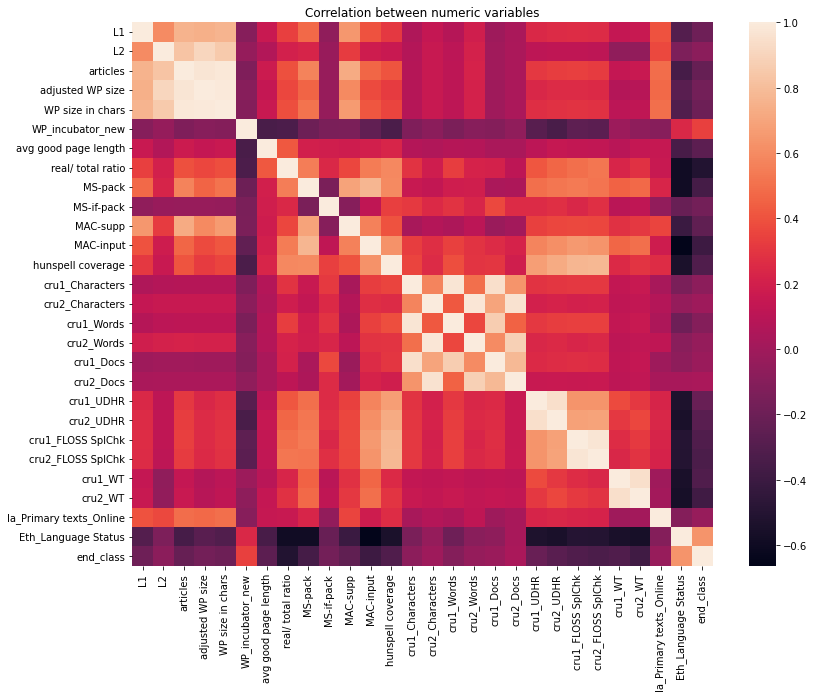

In [11]:
# Columns with numerical values
NUM_COLS = [
    L1,
    L2,
    WP_ART,
    WP_SIZE_ADJ, 
    WP_SIZE_CH, 
    WP_INCUB,
    WP_AVG_LEN,
    WP_REAL_TOT,
    MS_OS,
    MS_IN,
    MAC_OS,
    MAC_IN,
    HUN_COV,
    CR1_CH,
    CR2_CH,
    CR1_WORDS,
    CR2_WORDS,
    CR1_DOCS,
    CR2_DOCS,
    CR1_UDHR,
    CR2_UDHR,
    CR1_FLOSS,
    CR2_FLOSS,
    CR1_BIB,
    CR2_BIB,
    OLAC
]

STATUS_COLS = [
    ETHN,
    ELP,
]

# Correlation matrix of numerical values
f, ax = plt.subplots(figsize=(13, 10))
ax.set_title("Correlation between numeric variables")
corr = eur_dld_clean[NUM_COLS + STATUS_COLS].corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

<AxesSubplot:title={'center':'Enthologue status'}, xlabel='LangID'>

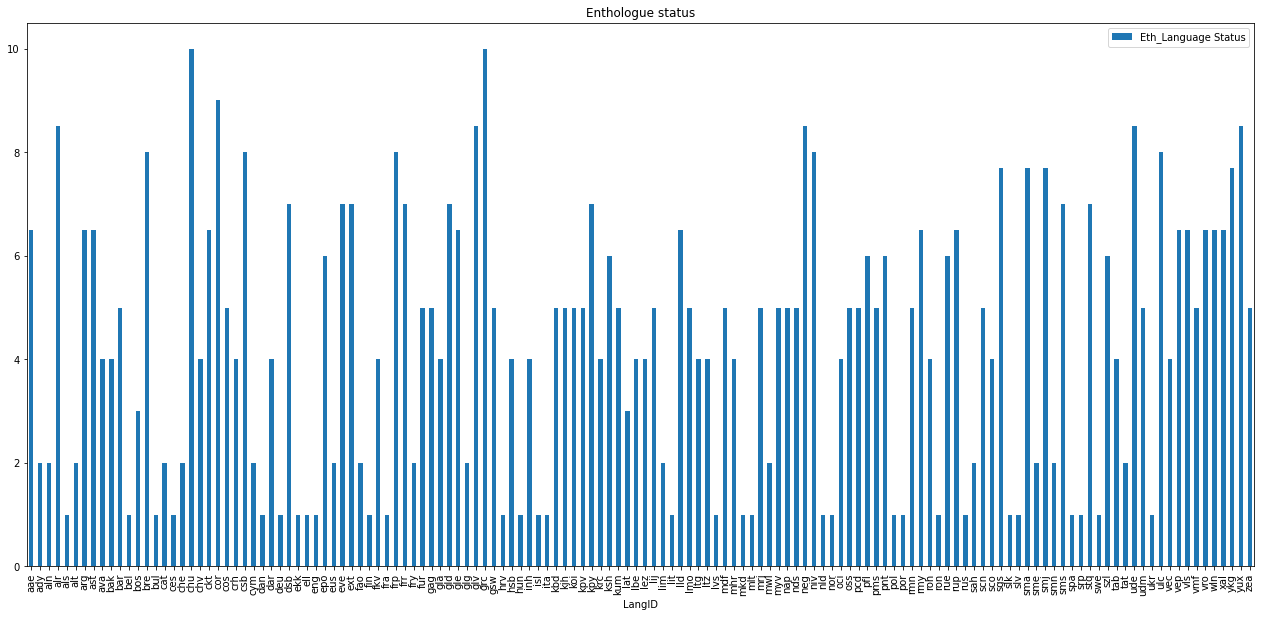

In [12]:
# Correlation with endangerment status of Ethnologue
eur_dld_clean.set_index(LANG_ID).sort_index().plot(y=ETHN, figsize=(22, 10), title="Enthologue status", kind="bar")

,Eth_Language Status
MAC-input,-0.663741
real/ total ratio,-0.590073
MS-pack,-0.587607
cru2_WT,-0.566121
cru1_WT,-0.548833
cru2_UDHR,-0.546941
hunspell coverage,-0.544136
cru1_UDHR,-0.529287
cru2_FLOSS SplChk,-0.502468
cru1_FLOSS SplChk,-0.495520


<AxesSubplot:title={'center':'Correlation with degree and availability of digital tools - Ethnologue'}>

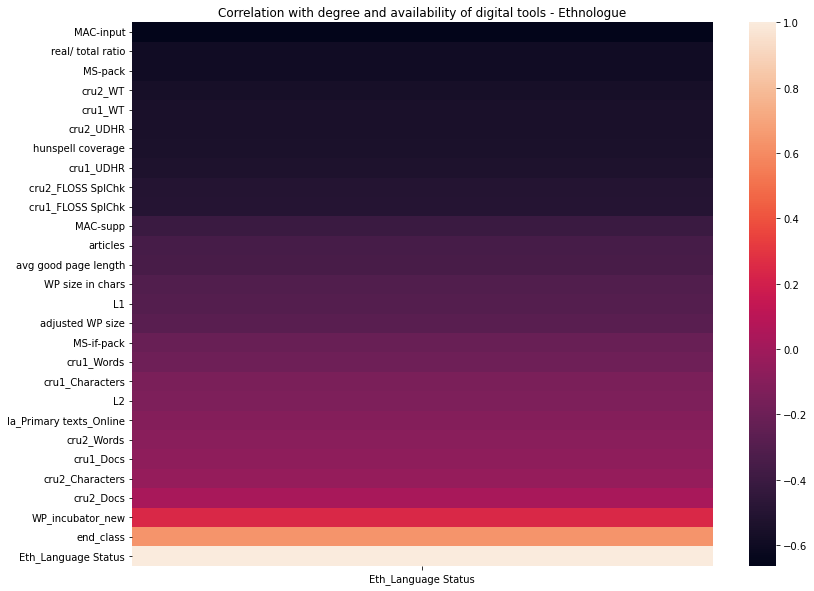

In [13]:
f, ax = plt.subplots(figsize=(13, 10))
ax.set_title("Correlation with degree and availability of digital tools - Ethnologue")

corr_ethn = corr[[ETHN]].sort_values(by=ETHN)
display(corr_ethn)
sns.heatmap(corr_ethn, 
        xticklabels=corr_ethn.columns,
        yticklabels=corr_ethn.index)

#### Fit model to find out most important factors

In [14]:
def create_dataset(data, label_to_predict, test_size=0.2, random_state=0):
    train, test = train_test_split(data, test_size=test_size, random_state=random_state)

    y = train[label_to_predict]
    y_true = test[label_to_predict]

    del train[label_to_predict]
    del test[label_to_predict]
    return train, test, y, y_true

def print_pred(y_true, y_pred, title):
    df = pd.DataFrame()
    df["y_true"] = y_true
    df["y_pred"] = y_pred
    df.sort_index().plot(y=["y_true", "y_pred"], figsize=(22, 10), title=title, kind="bar")
    
def print_coefs(cols, coefs):
    df = pd.DataFrame()
    df["Features"] = cols
    df["coefs"] = coefs
    df["coefs_abs"] = abs(coefs)
    display(df.sort_values(by="coefs_abs", ascending=False))
    
def print_score(y_true, y_pred, method):
    print(method(y_true, y_pred))

def fit(scaler, model, train, y, test, y_true, coefs=False, title=None):
    reg = make_pipeline(scaler, model)
    reg.fit(train, y)
    y_pred = reg.predict(test)
    print_score(y_true, y_pred, explained_variance_score)
    if coefs:
        print_coefs(train.columns, model.coef_)
    if title:
        print_pred(y_true, y_pred, title)
    return y_pred

In [15]:
# Create dataset
data = eur_dld_clean[NUM_COLS + [ETHN, LANG_ID]]
data.set_index("LangID", inplace=True)
train, test, y, y_true = create_dataset(data, ETHN, test_size=0.2, random_state=0)

-4.3965354501857705


,Features,coefs,coefs_abs
10,MAC-supp,-5.072919e+08,5.072919e+08
11,MAC-input,-2.110703e+08,2.110703e+08
8,MS-pack,-1.708168e+08,1.708168e+08
9,MS-if-pack,-3.701979e+07,3.701979e+07
21,cru1_FLOSS SplChk,1.334710e+07,1.334710e+07
12,hunspell coverage,1.227116e+07,1.227116e+07
7,real/ total ratio,8.289368e+06,8.289368e+06
22,cru2_FLOSS SplChk,-7.480005e+06,7.480005e+06
20,cru2_UDHR,2.953604e+05,2.953604e+05
23,cru1_WT,-1.933459e+05,1.933459e+05


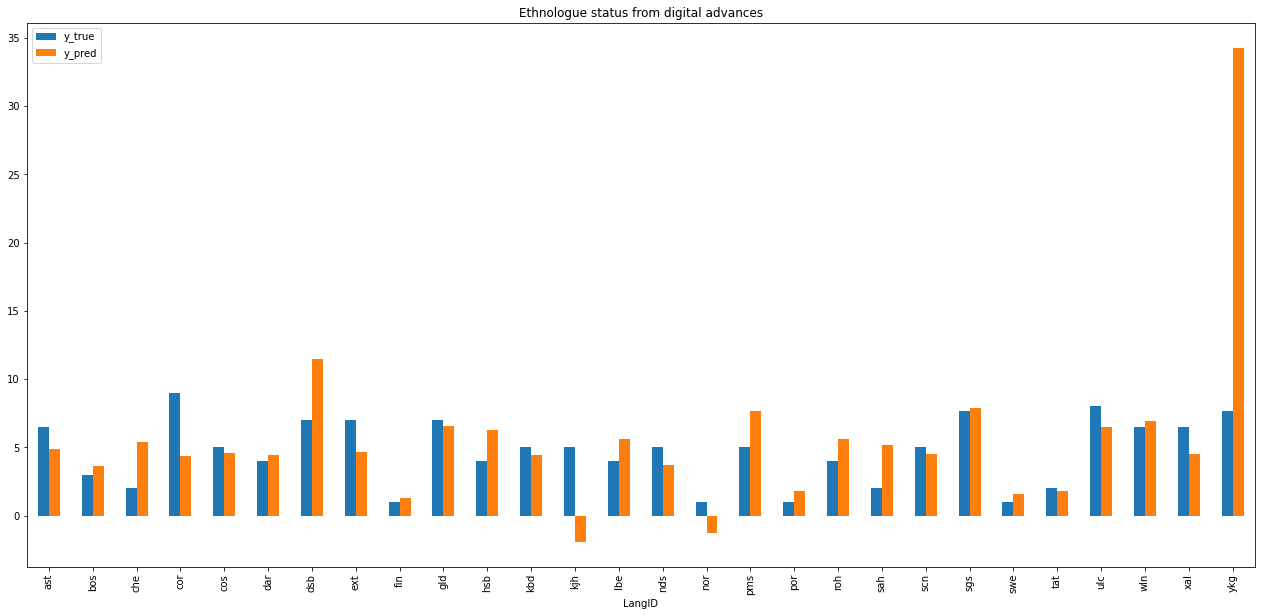

In [16]:
# Fit model
lr = LinearRegression()
y_pred_lr = fit(Normalizer(), lr, train, y, test, y_true, coefs=True, title="Ethnologue status from digital advances")

#### Conclusion

Most important digitalization factors for determining endangerment status:

- MAC and Windows OS level & input support
- The existence of a spellchecker and their word coverage.
- Ratio of real/total wikipedia pages.
- Availability of Bible and Universal Declaration of Human rights translations


Not so important features (for both metrics):

- Number of speakers.
- Character size of available resources.

## Minority / Official Languages, Migration

(Alexander Bek)

### Data Inspection and Preparation

#### Immigration

_Total number of long-term immigrants arriving into the reporting country during the reference year._

- information about data availabilty
https://ec.europa.eu/eurostat/web/main/data/database?p_p_id=NavTreeportletprod_WAR_NavTreeportletprod_INSTANCE_nPqeVbPXRmWQ&p_p_lifecycle=0&p_p_state=pop_up&p_p_mode=view&_NavTreeportletprod_WAR_NavTreeportletprod_INSTANCE_nPqeVbPXRmWQ_nodeInfoService=true&nodeId=-9012

- meta data: N/A
Last data update: 	27/04/2021  23:00 (8 months ago); Overall data coverage: 	2008 — 2019

Source data set: https://ec.europa.eu/eurostat/databrowser/product/view/MIGR_IMM1CTZ

special cases: ":" missing;
two sets: agedef = COMPLET (age in completed years) and REACH (age reached during the year), resp.

Missing values are indicated by a colon. 
Numbers may be accompanied by a 1- or 2-letter code with the following meaning:

- b: break in time series
- bp: break in time series, provisional
- p: provisional
- e: estimated
- ep: estimated, provisional

For the purpose of this study, this information is ignored and hence the characters removed, facilitating conversion of the data to numeric.

In [2]:
fileName = PATH_DATA + 'tps00176.tsv'
# header = 1st line; missing value indicated by colon (followed by a space)
data = pd.read_csv(fileName, sep='\t', na_values=[': '], header=0) 
VALUE_COLNAME = 'nImmigrants'  # name for new column containing value of timeseries

First column defines content of time series. 
There are two sets: agedef = COMPLET (age in completed years) and REACH (age reached during the year), resp. 
In each group, there is a row for each country of the European Union (last two letters of 1st column).
Since age is no criterion, the two sets are equal and only the first half of the data is considered.

In [3]:
# remove duplicates and transform first column (keep only country code)
keepNRows = data.shape[0] // 2 # keep first half of table (68 -> 34)
data = data.iloc[0:keepNRows, ]

# keep last two characters (country code) -> new first column 'country'
data.insert(0, 'country', data.iloc[ : , 0].apply(lambda s: s[-2: ])) 
data.head()

,country,"citizen,agedef,age,unit,sex,geo\time",2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,AT,"TOTAL,COMPLET,TOTAL,NR,T,AT",73772,69295,70978,82230,91557,101866,116262,166323,129509,111801,105633,109167
1,BE,"TOTAL,COMPLET,TOTAL,NR,T,BE",NaN,NaN,135281 b,147377 b,129477,120078,123158,146626,123702,126703,137860,150006
2,BG,"TOTAL,COMPLET,TOTAL,NR,T,BG",NaN,NaN,NaN,NaN,14103 bp,18570 p,26615 p,25223 p,21241,25597 p,29559 p,37929 p
3,CH,"TOTAL,COMPLET,TOTAL,NR,T,CH",184297,160623,161778,148799 b,149051,160157,156282,153627,149305,143377,144857,145129
4,CY,"TOTAL,COMPLET,TOTAL,NR,T,CY",21060,22581 b,20206,23037,17476,13149,9212,15183,17391,21306,23442,26170


In [4]:
# drop second column
colName = data.columns[1] 
data.pop(colName)
# convert year column names to integer 
yearColumns = range(2008,2020) 
newColumnNames = list(["country", *yearColumns])  # "*" unpacks range
data.columns = newColumnNames

,country,nImmigrants
year,,
2008,AT,73772.0
2008,BE,135281.0
2008,BG,14103.0
2008,CH,184297.0
2008,CY,21060.0


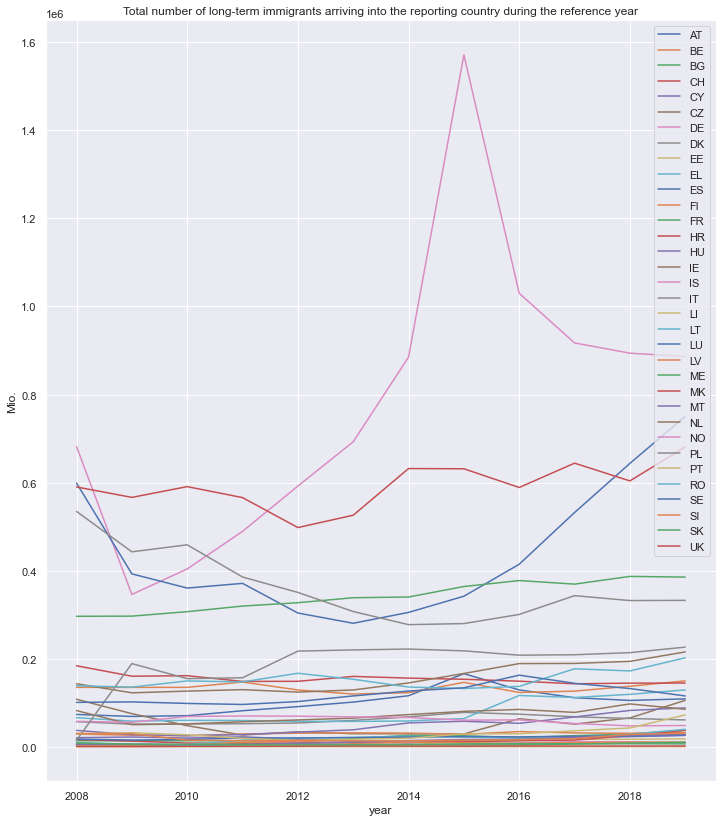

In [5]:
# -- cleanse data
# data.replace("[a-z]+", "", regex=True, inplace=True) # warning (could be ignored)
data = data.replace("[a-z]+", "", regex=True, inplace=False) # alternative

data.dtypes # all object
# -> convert all year columns of DataFrame to numeric (and ignore errors caused by country)
data = data.apply(pd.to_numeric, errors='ignore')

# year columns become attribute (pivoting wide to long -> melt())
# key is country (for each year and country, a row is to be created)
# use the year columns for the value column 
data = data.melt(['country'], value_vars = yearColumns, var_name = 'year', 
                                              value_name = VALUE_COLNAME) 
data.set_index(['year'], inplace = True)
# imputation: linear 
data = data.groupby('country').apply(lambda c: 
  c.interpolate(method = 'linear', limit_direction = 'both', axis = 0))
# -- plot timeseries ----
sns.set()
diagTitle = "Total number of long-term immigrants arriving into the reporting country during the reference year"
# all countries in 1 plot:
ax = data.groupby('country')[VALUE_COLNAME].plot(figsize = [12,14], legend=True, title=diagTitle,
                        ylabel = 'Mio.') 
# save processed data
data.to_csv(os.path.join(PATH_DATA, "population", "immigrants.csv"), index=True)
data.head()

#### Emigration

_Total number of long-term emigrants leaving from the reporting country during the reference year._

- information about data availabilty
https://ec.europa.eu/eurostat/web/main/data/database?p_p_id=NavTreeportletprod_WAR_NavTreeportletprod_INSTANCE_nPqeVbPXRmWQ&p_p_lifecycle=0&p_p_state=pop_up&p_p_mode=view&_NavTreeportletprod_WAR_NavTreeportletprod_INSTANCE_nPqeVbPXRmWQ_nodeInfoService=true&nodeId=-9012

- meta data: N/A
Last data update: 	13/03/2021 23:00, overall data coverage: 	2008 — 2019

Source data set: https://ec.europa.eu/eurostat/databrowser/product/view/MIGR_IMM1CTZ

Similar to immigration dataset.

,country,nEmigrants
year,,
2008,AT,51563.0
2008,BE,66013.0
2008,BG,16615.0
2008,CH,86130.0
2008,CY,4474.0


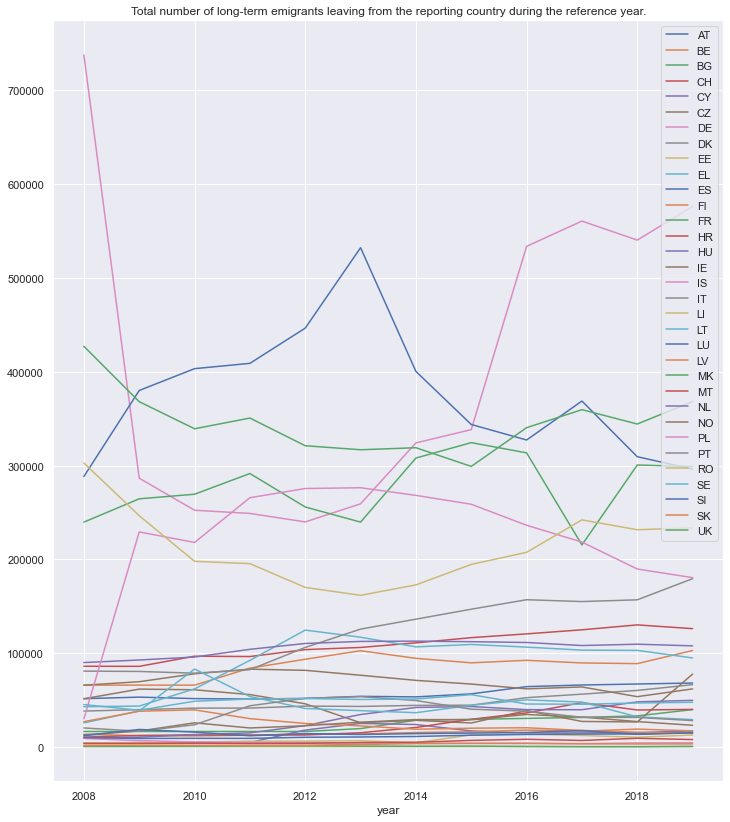

In [6]:
fileName = PATH_DATA + 'tps00177.tsv'
VALUE_COLNAME = 'nEmigrants'  # name for new column containing value of timeseries
# header = 1st line; missing value indicated by colon (followed by a space)
data = pd.read_csv(fileName, sep='\t', na_values=[': '], header=0) 
# remove duplicates and transform first column (keep only country code)
keepNRows = data.shape[0] // 2 # keep first half of table (68 -> 34)
data = data.iloc[0:keepNRows, ]
# keep last two characters (country code) -> new first column 'country'
data.insert(0, 'country', data.iloc[ : , 0].apply(lambda s: s[-2: ])) 
colName = data.columns[1] 
data.pop(colName)
yearColumns = range(2008,2020) # convert year column names to integer 
newColumnNames = list(["country", *yearColumns]) 
data.columns = newColumnNames
data[yearColumns]

# -- cleanse data
# data.replace("[a-z]+", "", regex=True, inplace=True) # warning (could be ignored)
data = data.replace("[a-z]+", "", regex=True, inplace=False) # alternative

data.dtypes # all object
# -> convert all year columns of DataFrame to numeric (and ignore errors caused by country)
data = data.apply(pd.to_numeric, errors='ignore')

# year columns become attribute (pivoting wide to long -> melt())
# key is country (for each year and country, a row is to be created)
# use the year columns for the value column 
data = data.melt(['country'], value_vars = yearColumns, var_name = 'year', 
                                              value_name = VALUE_COLNAME) 

# -- create an index
# data.set_index(['country', 'year'], inplace = True)
data.set_index(['year'], inplace = True)

# imputation: linear 
data = data.groupby('country').apply(lambda c: 
  c.interpolate(method = 'linear', limit_direction = 'both', axis = 0))

# -- plot timeseries ----
sns.set()
diagTitle = "Total number of long-term emigrants leaving from the reporting country during the reference year."
# 1 plot per country:
# _ = data.groupby('country').plot(figsize = [14,20]) 
# all countries in 1 plot:
_ = data.groupby('country')[VALUE_COLNAME].plot(figsize = [12,14], legend=True, title=diagTitle) 

# save processed data
data.to_csv(os.path.join(PATH_DATA, "population", "emigrants.csv"), index=True)
data.head()

#### Population

_The number of persons having their usual residence in a country on 1 January of the respective year. When usually resident population is not available, countries may report legal or registered residents._

- information about data availabilty
https://ec.europa.eu/eurostat/web/main/data/database?p_p_id=NavTreeportletprod_WAR_NavTreeportletprod_INSTANCE_nPqeVbPXRmWQ&p_p_lifecycle=0&p_p_state=pop_up&p_p_mode=view&_NavTreeportletprod_WAR_NavTreeportletprod_INSTANCE_nPqeVbPXRmWQ_nodeInfoService=true&nodeId=-9012

- meta data: N/A
Last data update: 	13/03/2021 23:00; Overall data coverage: 	2010 — 2021

Source data set: https://ec.europa.eu/eurostat/databrowser/product/view/MIGR_IMM1CTZ

In [7]:
fileName = PATH_DATA + 'tps00001.tsv'
# header = 1st line; missing value indicated by colon (followed by a space)
data = pd.read_csv(fileName, sep='\t', na_values=[': '], header=0) 
VALUE_COLNAME = 'nPopulation'  # name for new column containing value of timeseries

First column defines content of time series. 
First part is always JAN (=January) and may be ignored; second part is either 2-letter country code or a longer code of a group of countries; only the single countries are kept.

,country,nPopulation
year,,
2010,AD,84082.0
2010,AL,2918674.0
2010,AM,3249482.0
2010,AT,8351643.0
2010,AZ,8997586.0


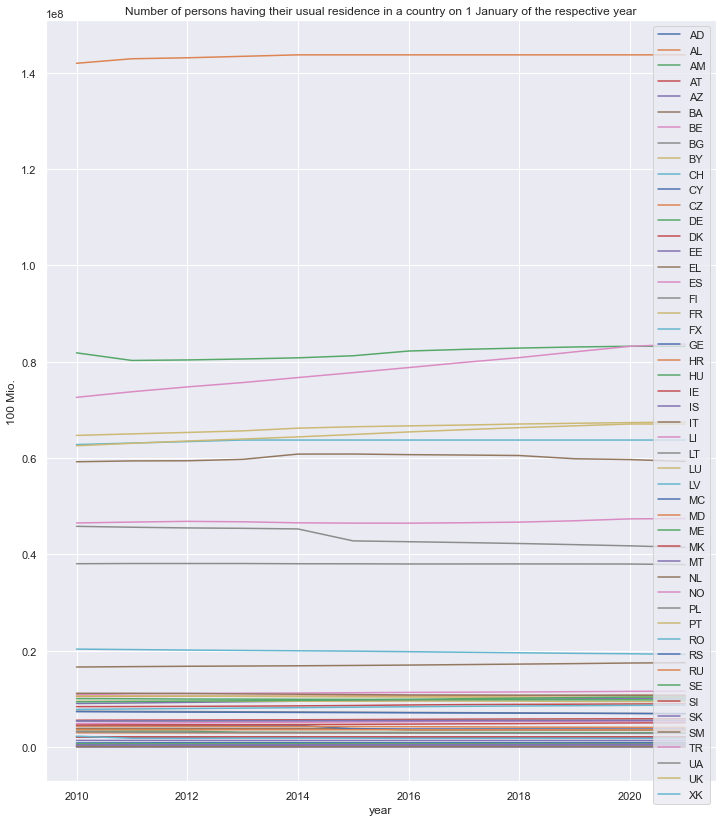

In [8]:
# filter rows of single countries
pattern = "[A-Z]{3},[A-Z]{2}"  # "JAN,<2-digit country code>"
colName = data.columns[0] 
data = data[data[colName].str.fullmatch(pattern)]
# transform first column (keep only last two characters (country code) -> new first column 'country'
data.insert(0, 'country', data.iloc[ : , 0].apply(lambda s: s[-2: ])) 
# drop second column
colName = data.columns[1] 
data.pop(colName)
# convert year column names to integer 
yearColumns = range(2010,2022) 
newColumnNames = list(["country", *yearColumns])  # "*" unpacks range
data.columns = newColumnNames

# -- cleanse data
# data.replace("[a-z]+", "", regex=True, inplace=True) # warning (could be ignored)
data = data.replace("[a-z]+", "", regex=True, inplace=False) # alternative

# convert all year columns of DataFrame to numeric (and ignore errors caused by country)
data = data.apply(pd.to_numeric, errors='ignore')

# year columns become attribute (pivoting wide to long -> melt())
# key is country (for each year and country, a row is to be created)
# use the year columns for the value column 
data = data.melt(['country'], value_vars = yearColumns, var_name = 'year', 
                                              value_name = VALUE_COLNAME) 

# -- create an index
#data.set_index(['country', 'year'], inplace = True)
data.set_index(['year'], inplace = True)

# imputation: linear 
data = data.groupby('country').apply(lambda c: 
  c.interpolate(method = 'linear', limit_direction = 'both', axis = 0))

# -- plot timeseries ----
sns.set()
diagTitle = "Number of persons having their usual residence in a country on 1 January of the respective year"
# 1 plot per country:
# _ = immigrationData.groupby('country').plot(figsize = [14,20]) 
# all countries in 1 plot:
_ = data.groupby('country')[VALUE_COLNAME].plot(figsize = [12,14], legend=True, title=diagTitle,
     ylabel = '100 Mio.') 

# save processed data
data.to_csv(os.path.join(PATH_DATA, "population", "population.csv"), index=True)
data.head()

#### Languages per country (official, minority)

From _The World Factbook_, a publication of the CIA, https://www.cia.gov/the-world-factbook/about/archives/, 
accessed on Dec 21, 2021.


In [9]:
fileName = PATH_DATA + 'countries_languages_all.csv'  
data = pd.read_csv(fileName, sep=',', header=0) # header = 1st line
data.head()

,Country,Recognized Languages
0,Afghanistan,Afghan Persian or Dari (official) 77% (Dari fu...
1,Albania,Albanian 98.8% (official - derived from Tosk d...
2,Algeria,"Arabic (official), French (lingua franca), Ber..."
3,Andorra,"Catalan (official), French, Castilian, Portuguese"
4,Angola,"Portuguese 71.2% (official), Umbundu 23%, Kiko..."


In [10]:
# Non-European countries to be  filtered out. Second (unstructured) column is transformed as follows:
# - Split text into 1 column per language
# - add one column for share / official (yes/no)
data = data.join(data['Recognized Languages'].str.split(',', expand=True)) # split column
data.pop('Recognized Languages') # drop split column
data.head()

,Country,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,Afghanistan,Afghan Persian or Dari (official) 77% (Dari fu...,Pashto (official) 48%,Uzbek 11%,English 6%,Turkmen 3%,Urdu 3%,Pashayi 1%,Nuristani 1%,Arabic 1%,Balochi 1% (2017 est.),None,None,None,None,None,None,None,None,None
1,Albania,Albanian 98.8% (official - derived from Tosk d...,Greek 0.5%,other 0.6% (including Macedonian,Romani,Vlach,Turkish,Italian,and Serbo-Croatian),unspecified 0.1% (2011 est.),None,None,None,None,None,None,None,None,None,None
2,Algeria,Arabic (official),French (lingua franca),Berber or Tamazight (official); dialects incl...,Shawiya Berber (Tacawit),Mzab Berber,Tuareg Berber (Tamahaq),None,None,None,None,None,None,None,None,None,None,None,None,None
3,Andorra,Catalan (official),French,Castilian,Portuguese,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,Angola,Portuguese 71.2% (official),Umbundu 23%,Kikongo 8.2%,Kimbundu 7.8%,Chokwe 6.5%,Nhaneca 3.4%,Nganguela 3.1%,Fiote 2.4%,Kwanhama 2.3%,Muhumbi 2.1%,Luvale 1%,other 3.6% (2014 est.),None,None,None,None,None,None,None


In [11]:
# create a row for each country-language combination (pivot wide -> long)
data = data.melt(['Country'], value_name = 'languageRaw', var_name = 'langId')
data = data.dropna() # remove empty languages
# note: the number of languages spoken in a given country is equal to max(langId)+1; 

In [12]:
# European languages only -> join with european_languages.csv
eur_lang = pd.read_csv(PATH_DATA + "general/european_languages.csv")
data = data[data.Country.isin(eur_lang.Name_country)] # semi join with European languages
data.set_index(['Country', 'langId'], inplace = True)

# mark official languages (new column official [Boolean])
pattern = "official"  
data['official'] = data['languageRaw'].str.contains(pattern)

# Extract actual language name, identified as the first capitalized word (this heuristic introduces some NA's)
pattern = r'(?P<language>[A-Z][a-z]+)'  # named group becomes new column 'language'
#data['languageRaw'].str.extract(pattern)
data = data.join(data['languageRaw'].str.extract(pattern))
data = data.dropna()
data.sort_values(by = ["Country", "langId"], inplace=True)

# data cleansing
data.drop(("Austria", 5), axis=0, inplace = True)
data.drop(("Ireland", 3), axis=0, inplace = True)
data.drop(("Ireland", 4), axis=0, inplace = True)
data.loc["United Kingdom", "official"] = True
data.loc[("Albania", 7), "language"] = "Croatian"
data.loc[("Austria", 7), "language"] = "Burgenland Croatian"

# save processed data
data.to_csv(os.path.join(PATH_DATA, "general", "countries_languages_eur.csv"), index=True)
data.head()

languageRaw  official  \
Country langId                                                                
Albania 0       Albanian 98.8% (official - derived from Tosk d...      True   
        1                                              Greek 0.5%     False   
        2                        other 0.6% (including Macedonian     False   
        3                                                  Romani     False   
        4                                                   Vlach     False   

                  language  
Country langId              
Albania 0         Albanian  
        1            Greek  
        2       Macedonian  
        3           Romani  
        4            Vlach

In [13]:
# get endangerment status
endangered = pd.read_csv(PATH_DATA + "endangerment/endangered_languages_europe.csv")
# join with endangered_languages_europe.csv
endangered = endangered[["Name in English", "Endangerment code"]]
data.reset_index(inplace=True)
dataEndangered = pd.merge(data, endangered, how='left', left_on=['language'], right_on=["Name in English"])

# define class: Endangerment code NaN -> 0 (not endangered), integer -> 1 (endangered)
dataEndangered['endangered'] = [0 if pd.isna(ec) else 1 for ec in dataEndangered['Endangerment code']]
# join with European languages for country code
eur_lang = eur_lang[["CountryID", "Name_country"]]
eur_lang = eur_lang.drop_duplicates()
dataLang = pd.merge(dataEndangered, eur_lang, how='left', left_on=['Country'], right_on=["Name_country"])
dataLang.drop(columns =["langId", "languageRaw", "Name in English", "Name_country"], inplace=True)
dataLang.head()

,Country,official,language,Endangerment code,endangered,CountryID
0,Albania,True,Albanian,NaN,0,AL
1,Albania,False,Greek,NaN,0,AL
2,Albania,False,Macedonian,NaN,0,AL
3,Albania,False,Romani,2.0,1,AL
4,Albania,False,Vlach,NaN,0,AL


In [14]:
# join with population, immigrants, emigrants
population = pd.read_csv(PATH_DATA + "population/population.csv") 
populationProject= pd.read_csv(PATH_DATA + "population/populationProject.csv") 
emigrants = pd.read_csv(PATH_DATA + "population/emigrants.csv") 
immigrants = pd.read_csv(PATH_DATA + "population/immigrants.csv") 
timeSeriesData = pd.merge(population, emigrants, how='outer', on=['year', 'country']) # join time series
timeSeriesData = pd.merge(timeSeriesData, immigrants, how='outer', on=['year', 'country'])
# use summary statistics
timeSeriesMedian = timeSeriesData.loc[:, timeSeriesData.columns != 'year'].groupby('country').median()
timeSeriesMedian.reset_index(inplace=True)
dataLang = pd.merge(dataLang, timeSeriesMedian, how='left', left_on=['CountryID'], right_on=['country'])
dataLang.drop(columns =["country"], inplace=True)
dataLang
# add internet users
internetUsers = pd.read_csv(PATH_DATA + "number-of-internet-users-by-country.csv") # TBD directory
# use summary statistics
internetUsersMedian = internetUsers.loc[:, internetUsers.columns != 'Year'].groupby('Entity').median()
dataLang = pd.merge(dataLang, internetUsersMedian, how='left', left_on=['Country'], right_on=['Entity'])
# rename some columns
dataLang.rename(columns={"Number of internet users (OWID based on WB & UN)": "nInternetUsers", "Country": "country",
                        "Endangerment code": "endangerment"}, inplace = True)
# save joined tables
dataLang.to_csv(os.path.join(PATH_DATA, "general", "trainTest.csv"), index=True)
dataLang.head()

,country,official,language,endangerment,endangered,CountryID,nPopulation,nEmigrants,nImmigrants,nInternetUsers
0,Albania,True,Albanian,NaN,0,AL,2881193.5,NaN,NaN,186102.0
1,Albania,False,Greek,NaN,0,AL,2881193.5,NaN,NaN,186102.0
2,Albania,False,Macedonian,NaN,0,AL,2881193.5,NaN,NaN,186102.0
3,Albania,False,Romani,2.0,1,AL,2881193.5,NaN,NaN,186102.0
4,Albania,False,Vlach,NaN,0,AL,2881193.5,NaN,NaN,186102.0


###  Classifiers

Country-language pairs are assigned class 1 (endangered) or 0 (not endangered), respectively.

In [15]:
# training/test data
X = dataLang[['official', 'nPopulation', 'nEmigrants', 'nImmigrants', 'nInternetUsers']]
y = dataLang.endangered
X = X.fillna(0)
# Train and Test splitting of data
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=25)
# Applying Standard scaling (zero mean and unit variance)
# Output is numpy.ndarray
sc = preprocessing.StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

#### Count (Not) Endangered Cases

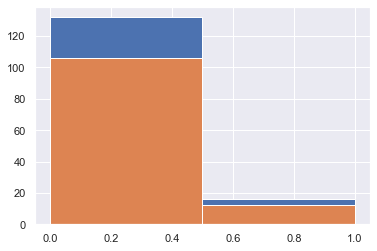

In [16]:
y.hist(bins=2);
y_train.hist(bins=2);

__Orange:__ Training, __Blue:__ Test

__Left:__ Not Endangered, __Right:__ Endangered

#### KNN

In [17]:
knn=neighbors.KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)
knnresult=knn.predict(X_test)
print("KNN ",knn.score(X_test,y_test))
print(metrics.confusion_matrix(y_test,knnresult))

KNN  0.8666666666666667
[[26  0]
 [ 4  0]]


In [18]:
# Cross-validation
print("\nCross Validation")
print("KNN")
scores = model_selection.cross_val_score(knn, X_train, y_train, cv=5)
print(scores)
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()))


Cross Validation
KNN
[0.875      0.83333333 0.875      0.91304348 0.91304348]
Accuracy: 0.882 (+/- 0.030)


In [19]:
# Grid Search
kvals=list(range(1,20,2))
knng=model_selection.GridSearchCV(estimator=knn, param_grid=dict(n_neighbors=kvals), cv=5)
knng.fit(X_train,y_train)
print("KNN Best Score: %0.3f, Best Estimator: %f" % (knng.best_score_,knng.best_estimator_.n_neighbors))
knnresult=knng.predict(X_test)
print("KNN ",knng.score(X_test,y_test))
print(metrics.confusion_matrix(y_test,knnresult))

KNN Best Score: 0.899, Best Estimator: 7.000000
KNN  0.8666666666666667
[[26  0]
 [ 4  0]]


#### SVM

In [20]:
# SVM
clf=svm.LinearSVC(C=0.1)
clf.fit(X_train,y_train)
svmresult=clf.predict(X_test)
print("Linear SVM ",clf.score(X_test,y_test))
print(metrics.confusion_matrix(y_test,svmresult))

Linear SVM  0.8666666666666667
[[26  0]
 [ 4  0]]


In [21]:
kernelsvm=svm.SVC(kernel='linear',C=0.1)
kernelsvm.fit(X_train,y_train)
svmresult=kernelsvm.predict(X_test)
print("Linear SVM (non-opt) ",kernelsvm.score(X_test,y_test))
print(metrics.confusion_matrix(y_test,svmresult))

Linear SVM (non-opt)  0.8666666666666667
[[26  0]
 [ 4  0]]


In [22]:
kernelsvm=svm.SVC(kernel='rbf',C=1.3,gamma=1.3)
kernelsvm=svm.SVC(kernel='poly',C=1,gamma='auto')
kernelsvm=svm.SVC(kernel='sigmoid',C=1,gamma='auto')
kernelsvm.fit(X_train,y_train)
svmresult=kernelsvm.predict(X_test)
print("Kernel SVM ",kernelsvm.score(X_test,y_test))
print(metrics.confusion_matrix(y_test,svmresult))

Kernel SVM  0.8666666666666667
[[26  0]
 [ 4  0]]


#### Decision Tree

In [23]:
# Decision Tree
dtree=tree.DecisionTreeClassifier(criterion='entropy')
dtree.fit(X_train,y_train)
dtreeresult=dtree.predict(X_test)
print("TREE ",dtree.score(X_test,y_test))
print(metrics.confusion_matrix(y_test,dtreeresult))

TREE  0.8666666666666667
[[26  0]
 [ 4  0]]


#### Random Forest

In [24]:
rfc = RandomForestClassifier(n_estimators=2500,random_state=0)
rfc.fit(X_train,y_train)
rfcresult=rfc.predict(X_test)
print("Random Forest ",rfc.score(X_test,y_test))
print(metrics.confusion_matrix(y_test,rfcresult))

Random Forest  0.8666666666666667
[[26  0]
 [ 4  0]]


Conclusion: Language status in the countries where it is spoken does not facilitate identification of endangered languages.

## How does the use of communication languages in different countries change over time?

(Evelyn Birnzain)

### Introduction
For a well-rounded impression of how communication languages in each country of the EU change over time, cleaned and aggregated the following survey microdata, polled between the years of 1990 to 2012:

* [Eurobarometer 34.0 (Oct-Nov 1990)](https://www.gesis.org/en/eurobarometer-data-service/survey-series/standard-special-eb/study-overview/eurobarometer-340-za-1960-oct-nov-1990)
* [Eurobarometer 41.0 (Mar-May 1994)](https://www.gesis.org/en/eurobarometer-data-service/survey-series/standard-special-eb/study-overview/eurobarometer-410-za-2490-mar-may-1994)
* [Eurobarometer 44.0 (Oct-Nov 1995)](https://www.gesis.org/en/eurobarometer-data-service/survey-series/standard-special-eb/study-overview/eurobarometer-440-za-2689-oct-nov-1995)
* [Eurobarometer 50.0 (Oct-Nov 1998)](https://www.gesis.org/en/eurobarometer-data-service/survey-series/standard-special-eb/study-overview/eurobarometer-500-za-3085-oct-nov-1998)
* [Eurobarometer 52.0 (Oct-Nov 1999)](https://www.gesis.org/en/eurobarometer-data-service/survey-series/standard-special-eb/study-overview/eurobarometer-520-za-3204-oct-nov-1999)
* [Eurobarometer 54LAN  (Dec 2000)](https://www.gesis.org/en/eurobarometer-data-service/survey-series/standard-special-eb/study-overview/eurobarometer-54lan-za-3389-dec-2000)
* [Eurobarometer 55.1  (April-May 2001)](https://www.gesis.org/en/eurobarometer-data-service/survey-series/standard-special-eb/study-overview/eurobarometer-551-za-3507-apr-may-2001)
* [Eurobarometer 63.4 (May-Jun 2005)](https://search.gesis.org/research_data/ZA4411)
* [Eurobarometer 64.3 (Nov- Dec 2005)](https://www.gesis.org/en/eurobarometer-data-service/survey-series/standard-special-eb/study-overview/eurobarometer-643-za-4415-nov-dec-2005)
* [Eurobarometer 77.1 (2012)](https://dbk.gesis.org/dbksearch/SDesc2.asp?ll=10&notabs=1&af=&nf=&search=&search2=&db=E&no=5597) 

#### Selected survey questions for L1 and L2
As the amount and depth of questions varies, we only track L1 (native tongue) and L2 (foreign language). This data is inferred from the following questions.

* Origin *country* of sample.
* *L1 data*. Languages provided as answers to the following questions:
    1. What is you mother tongue? (LM)
    2. What language do you speak at home? (LH) (only somewhat reflects mother tongue)
* *L2 data*. Languages provided as answers to the following questions:
    1. What is your second/third/fourth/etc. language? Which languages have you learned, except your mothertongue? (LL)
    3. Which languages do you speak well enough to hold a conversation, except your mothertongue? (LS)
    
Answers could be provided both in single and multiple choice.

#### Encoding
* Multiple choice, `n` options: `n` consecutive columns (mostly) with key `v{question number i}` corresponding to one language each, e.g. `v123` might indicate the answers for French. Answers are indicated (mostly) with `(not) mentioned`. Order and possible selection of languages vary between surveys and must be provided separately (see below).
* Single: Single column with key `v{question number}` Language as string or missing. `DK` if the question could not be answered.


#### Reproducability / Input
* `data/raw_data`:
    * Survey microdata (see links) in `.sav` format . Prefix filenames with `EB{ survey number }_`.
    * Newline separated language choices `langs_{survey number}.txt`used for multiple choice questions.

### Preprocessing of survey microdata

The data is provided in `.sav` format, which can be conveniently loaded with pandas.

In [16]:
def open_survey(survey):
    """
    Load SPSS dataframe
    """
    path = f'{in_dir}{survey}.sav'
    df = pd.read_spss(path)
    return df

As for multiple choice questions it cannot be inferred which column stands for which language, a manually generated file must be provided for this. The data is gathered from the survey's corresponding codebook.

In [17]:
def get_langs(filename):
    """
    Load list of languages used for multiple choice questions
    """
    with open(f'{in_dir}{filename}') as fp:
        ls = [l.title() for l in fp.read().split('\n')]
        print(" ".join(ls))
        return ls

As questions can be single or multiple choice for both L1 and L2 data, we use a multiple choice encoding for both.

If the question is already in multiple choice format, we just have to rename to columns to make them understandable and be able to merge them across surveys.

In [18]:
def rename(df, frm, to, ls, new_prefix, old_prefix='v'):
    """
    Clean up question data provided in multiple choice format/wide form, i.e. `n` columns named `{old prefix}{i}` with `i` in `[frm, to]`. 
    Map values to 1 and 0 indicating mentioned or not mentioned respectively. 
    Rename columns to be easily readable and mergeable, e.g. `{new prefix}_{language name}`. 
    The language name is decoded from the column index according to the list of choices of languages (`ls`). 
    
    [frm, to] - range of column numbers belonging to the question
    ls - list of languages corresponding to the columns indicated by frm, to
    new_prefix - prefix for the new column names
    old_prefix - prefix for the column names
    """
    keys = [f'{old_prefix}{i}' for i in range(frm, to + 1)]
    if len(keys) != len(ls):
        print('Warning: Languages might not match columns')
    d = df[keys].astype(object)\
        .fillna(0)\
        .apply(lambda x: x.str.lower())\
        .replace('mentioned', 1)\
        .replace({'not mentioned': 0})\
        .fillna(0)\
        .astype(int)
    new_keys = [f'{new_prefix}_{l}' for l in ls]
    d = d.rename(dict(zip(keys, new_keys)), axis=1)
    d = d.drop([f'{new_prefix}_Dk', f'{new_prefix}_None'], axis=1, errors='ignore')
    return d

If a question is single choice, it will be one one column containing language keys. We need to pivot it into wide format.

In [19]:
def piv(df, nq, new_prefix="L2", old_prefix="v", ls=None):
    """
    Pivot answers to single choice questions from one column containing the language string to `n` columns with 0/1 encoding 
    (for compatibility with multiple choice questions). 
    
    nq - column number for the question
    new_prefix - prefix for the new column names
    old_prefix - prefix for the column names
    ls - List of languages which should appear as columns. Will be inferred from column values if not given.
    """
    key = f'{old_prefix}{nq}'
    df[key] = df[key].str.title()
    dk = df[key].fillna('None').astype(str).to_frame().replace(['No Second Language', 'No Third Language', 'Dk'], 'None')
    d = new_prefix + '_' + dk
    d['cnt'] = 1
    d = d.pivot(columns=key).fillna(0).astype(int)
    d.columns = d.columns.droplevel()
    
    if ls:
        cols = set([c.split('_')[1] for c in d.columns])
        diff = set(ls) - set(cols)
        d[[f'{new_prefix}_{l}' for l in diff]] = 0
        
    d = d.drop([f'{new_prefix}_Dk', f'{new_prefix}_None'], axis=1, errors='ignore')
    return d


#### Utility functions

In [20]:
def plot_valuecounts(L1, L2, idx):
    """
    Plot barplots - how many respondents gave 1, 2, etc. languages as their first/second languages
    
    L1 - Dataframe indicating whether a language was mentioned as L1 or not, using 0 and 1
    L2 - Dataframe indicating whether a language was mentioned as L2 or not, using 0 and 1
    idx - Rows of L1 to include
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))
    l1c = L1.loc[idx].sum(axis=1).value_counts()
    l2c = L2.sum(axis=1).value_counts()
    ax1.bar(l1c.index, l1c.values)
    ax1.set_xlabel('Number of languages mentioned as L1')
    ax1.set_ylabel('Count')
    ax2.bar(l2c.index, l2c.values)
    ax1.set_ylabel('Count')
    ax2.set_xlabel('Number of languages mentioned as L2')
    
def delete_duplicates_from_L2(L1, L2):
    """
    Set languages to 0 for L2 if they were mentioned as L1, as the respondent's mother tongue should not be counted as foreign language.
    
    L1 - Dataframe indicating whether a language was mentioned as L1 or not, using 0 and 1
    L2 - Dataframe indicating whether a language was mentioned as L2 or not, using 0 and 1
    """
    l_intersec = set([ c.split('_')[1] for c in L1.columns]).intersection([ c.split('_')[1] for c in L2.columns])
    for l in l_intersec:
        if l == 'Other':
            continue
        and_idx = L2['L2_' + l] * L1['L1_' + l]
        and_idx = and_idx.astype(bool)
        if and_idx.sum() > 0:
            print(l, 'mentioned both for L1 and L2:', and_idx.sum())
        L2.loc[and_idx, 'L2_' + l] = 0
    return L2

def concat_and_save(nat, L1, L2, year, survey, idx=None):
    """
    Concat arguments into one dataframe containing nationality, indicated L1 and L2, and year of the survey and save it in csv format. 
    Only consider the rows/respondents indicated by idx. Plot distribution of number of L1/L2 given.
    
    nat - Series indicating nationality of respondents
    L1 - Dataframe indicating whether a language was mentioned as L1 or not, using 0 and 1
    L2 - Dataframe indicating whether a language was mentioned as L2 or not, using 0 and 1
    year - Year the survey was held in
    idx - Rows of L1 to include
    """
    L2 = delete_duplicates_from_L2(L1, L2)
    res = pd.concat([nat, L1, L2], axis=1)
    lcols = list(L1.columns) + list(L2.columns)
    res.loc[:, lcols] = res.loc[:, lcols].clip(0, 1)
    res = res.drop('L2_nan', axis=1, errors='ignore') # 
    res['Year'] = year
    
    if idx is not None:
        res = res.loc[idx, :].reset_index(drop=True)
        
    res.to_csv(f'{step1_dir}{survey}.csv', index=False)
    plot_valuecounts(L1, L2, idx)    
    return res

#### Example - Eurobarometer 77.1 (2012)

In [24]:
%%time

survey = 'EB771_2012_ZA5597_v3-0-0'
year = 2012
df = open_survey(survey)

Wall time: 1min 4s


Read the manually generated language file providing the mapping from multiple choice column keys to languages.

In [25]:
ls = get_langs('languages_771.txt')

Arabic Basque Bulgarian Catalan Chinese Croatian Czech Danish Dutch English Estonian Finnish French Galician German Greek Hindi Hungarian Irish / Gaelic Italian Japanese Korean Latvian Lithuanian Luxembourgish Maltese Polish Portuguese Romanian Russian Scottish Gaelic Slovak Slovenian Spanish Swedish Turkish Urdu Welsh Other


#### --> L1 data

*Question:* Thinking about the languages that you speak, which language is your mother tongue? (multiple answers possible)

As the L1 data is in multiple choice/wide format, just rename the columns. Also, find respondents who didn't answer the question in order to exclude them later.

In [26]:
L1 = rename(df, 1, 39, ls, "L1", old_prefix='d48a_')
rows = L1[L1.sum(axis=1) > 0].index

#### --> L2 data

*Questions:* And which other language, if any, do you speak well enough in order to be able to have a conversation? (3x)

As the L2 data is in single choice/long format, pivot it to match the other data's wide format.

In [27]:
cols = [f"L2_{l}" for l in ls if l != 'None']
L2 = pd.DataFrame(index=L1.index, columns=cols).fillna(0)
for nq in ['b', 'c', 'd']:
    d = piv(df, nq, old_prefix='d48', ls=ls)
    L2 = L2 + d

#### --> Join country, L1, and L2 data and save

Danish mentioned both for L1 and L2: 1
Italian mentioned both for L1 and L2: 1
German mentioned both for L1 and L2: 1


,L1_Arabic,L1_Basque,L1_Bulgarian,L1_Catalan,L1_Chinese,L1_Croatian,L1_Czech,L1_Danish,L1_Dutch,L1_English,...,L2_Russian,L2_Scottish Gaelic,L2_Slovak,L2_Slovenian,L2_Spanish,L2_Swedish,L2_Turkish,L2_Urdu,L2_Welsh,Year
isocntry,,,,,,,,,,,,,,,,,,,,,
AT,2,0,3,3,1,21,1,1,3,2,...,18,0,2,9,47,4,3,0,0,2074372
BE,31,0,2,0,2,2,0,4,585,5,...,6,0,1,0,51,1,4,0,0,2114612
BG,0,0,956,0,0,1,0,0,0,2,...,261,0,0,0,20,0,21,0,0,2024072
CY,4,0,2,0,0,0,0,0,0,5,...,19,0,1,0,8,2,15,0,0,1018072
CZ,0,0,0,0,0,0,977,0,0,7,...,132,0,163,0,7,0,0,0,0,2018036


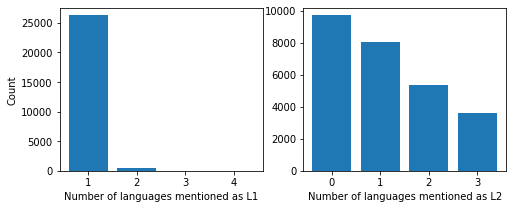

In [28]:
nat = df['isocntry']
res = concat_and_save(nat, L1, L2, year, survey, idx=rows)  
res.groupby('isocntry').sum().head()

The remaining surveys are preprocessed in much the same way and are left out in this notebook for brevity. 

For detailed processing see: https://github.com/Eszti/lang-changes/blob/main/notebooks/Evelyn/eurobarometer_preprocessing_step1.ipynb

### Combine + final cleanup on the preprocessed survey data

Combine the individually preprocessed dfs and drop columns for languages not mentioned by any of the respondents.

In [29]:
dfs = []
for filepath in glob.glob(step1_dir + "*"):
    dfs.append(pd.read_csv(filepath))
    
eval_df = pd.concat(dfs, ignore_index=True)
eval_df = eval_df.loc[:, eval_df.sum() != 0]
eval_df = eval_df.rename({'isocntry': 'Country'}, axis=1)

Combine survey results for Irish/Gaelic, Irish, and Scottish Gaelic and treat them as one language.

In [30]:
def fillna(eval_df, lang1, lang2):
    """
    Fill NaNs in L1 and L2 columns for lang1 with values from column for lang2.
    Reasoning: Languages might not occur under the name name in every survey, but results should be unified under one name.
    """
    _combine_inplace(eval_df, f'L1_{lang1}', f'L1_{lang2}')
    _combine_inplace(eval_df, f'L2_{lang1}', f'L2_{lang2}')

def _combine_inplace(eval_df, key1, key2):
    eval_df[key1].fillna(eval_df[key2], inplace=True)
    eval_df.drop(key2, inplace=True, axis=1)

fillna(eval_df, 'Irish / Gaelic', 'Irish')
fillna(eval_df, 'Irish / Gaelic', 'Scottish Gaelic')

Some surveys go into more detail language-wise and ask about particular dialects, regional or foreign languages which are not polled in the majority of the available surveys. Just treat them as "other" language in the future, as time series analysis does not make sense in those cases.

In [31]:
# Find the 12 L1/L2s which appear in the fewest surveys.
least_commonly_asked = eval_df.isna().sum().nlargest(12) / len(eval_df)

ls = least_commonly_asked.index
l1s = [l for l in ls if l.startswith('L1')]
l2s = [l for l in ls if l.startswith('L2')]

def sum_columns(eval_df, key, cols):
    """
    For any respondent who mentioned one of the languages in cols, set 'other' language mentioned to 1. 
    Drop cols from data.
    
    key - Column which should take on OR(cols)
    cols - Columns to combine and drop
    """
    
    cols = eval_df.columns.intersection(cols)
    n_other = eval_df[key].sum()
    eval_df[[key, *cols]].fillna(0).drop_duplicates()
    eval_df[key] = eval_df[key] + eval_df[cols].fillna(0).sum(axis=1)
    eval_df[key] = eval_df[key].clip(0,1)
    eval_df = eval_df.drop(cols, axis=1, errors='ignore')
    print(f"Number of respondents who mentioned one of the given languages: {eval_df[key].sum() - n_other}/{len(eval_df)}, i.e. {(eval_df[key].sum() - n_other)/len(eval_df)*100}%")
    
    return eval_df

eval_df = sum_columns(eval_df, 'L1_Other', l1s)
eval_df = sum_columns(eval_df, 'L2_Other', l2s)

Number of respondents who mentioned one of the given languages: 176.0/203228, i.e. 0.08660223984883973%
Number of respondents who mentioned one of the given languages: 971.0/203228, i.e. 0.4777884937114964%


### Aggregate and visualize trends

Aggregate microdata and normalize, since the number of respondents is wildly different for each year and country.

In [32]:
n = eval_df.groupby(['Country', 'Year']).size()
agg = eval_df.groupby(['Country', 'Year']).sum()
display(agg.head())
agg = agg.div(n, axis=0)
agg.to_csv(step2_dir + 'eval_df_wide.csv')
agg.head()

L1_Danish  L1_German  L1_French  L1_Italian  L1_Dutch  \
Country Year                                                          
AT      1995          5        980          3           1         0   
        1998          1        989          2           3         0   
        1999          5        985          0           0         2   
        2000          6        933          7           2         0   
        2001          2        998          3           0         1   

              L1_English  L1_Spanish  L1_Portuguese  L1_Greek  L1_Other  ...  \
Country Year                                                             ...   
AT      1995           1           0              0         1      11.0  ...   
        1998           8           2              0         2      34.0  ...   
        1999           5           1              0         1      17.0  ...   
        2000          13           0              0         5      28.0  ...   
        2001           3           1              0         1      25.0  ...   

              L2_Polish  L2_Romanian  L2_Slovak  L2_Slovenian  L1_Galician  \
Country Year                                                                 
AT      1995        0.0          0.0        0.0           0.0          0.0   
        1998        0.0          0.0        0.0           0.0          0.0   
        1999        0.0          0.0        0.0           0.0          0.0   
        2000        0.0          0.0        0.0           0.0          0.0   
        2001        0.0          0.0        0.0           0.0          0.0   

              L1_Hindi  L1_Urdu  L2_Galician  L2_Hindi  L2_Urdu  
Country Year                                                     
AT      1995       0.0      0.0          0.0       0.0      0.0  
        1998       0.0      0.0          0.0       0.0      0.0  
        1999       0.0      0.0          0.0       0.0      0.0  
        2000       0.0      0.0          0.0       0.0      0.0  
        2001       0.0      0.0          0.0       0.0      0.0  

[5 rows x 74 columns]

L1_Danish  L1_German  L1_French  L1_Italian  L1_Dutch  \
Country Year                                                          
AT      1995   0.004985   0.977069   0.002991    0.000997  0.000000   
        1998   0.000959   0.948226   0.001918    0.002876  0.000000   
        1999   0.004912   0.967583   0.000000    0.000000  0.001965   
        2000   0.006122   0.952041   0.007143    0.002041  0.000000   
        2001   0.001932   0.964251   0.002899    0.000000  0.000966   

              L1_English  L1_Spanish  L1_Portuguese  L1_Greek  L1_Other  ...  \
Country Year                                                             ...   
AT      1995    0.000997    0.000000            0.0  0.000997  0.010967  ...   
        1998    0.007670    0.001918            0.0  0.001918  0.032598  ...   
        1999    0.004912    0.000982            0.0  0.000982  0.016699  ...   
        2000    0.013265    0.000000            0.0  0.005102  0.028571  ...   
        2001    0.002899    0.000966            0.0  0.000966  0.024155  ...   

              L2_Polish  L2_Romanian  L2_Slovak  L2_Slovenian  L1_Galician  \
Country Year                                                                 
AT      1995        0.0          0.0        0.0           0.0          0.0   
        1998        0.0          0.0        0.0           0.0          0.0   
        1999        0.0          0.0        0.0           0.0          0.0   
        2000        0.0          0.0        0.0           0.0          0.0   
        2001        0.0          0.0        0.0           0.0          0.0   

              L1_Hindi  L1_Urdu  L2_Galician  L2_Hindi  L2_Urdu  
Country Year                                                     
AT      1995       0.0      0.0          0.0       0.0      0.0  
        1998       0.0      0.0          0.0       0.0      0.0  
        1999       0.0      0.0          0.0       0.0      0.0  
        2000       0.0      0.0          0.0       0.0      0.0  
        2001       0.0      0.0          0.0       0.0      0.0  

[5 rows x 74 columns]

Bring aggregate data into long form for more efficient handling and easy plotting, and estimate some data for smoother plotting. 

In [35]:
def ldata_wide_to_long(data):
    x = data.reset_index().reset_index().rename({'index': 'id'}, axis=1)
    x = pd.wide_to_long(x, stubnames=['L1','L2'], i='id',j='Language', sep='_', suffix='.*')
    x = x.reset_index().set_index(['Country', 'Language'])
    x = x.loc[x.groupby(['Country', 'Language']).size() > 2]
    x = x.reset_index()
    x = x.reset_index().drop('id', axis=1)
    return x

agg_long = ldata_wide_to_long(agg)
a = agg_long.replace(0, np.NaN).groupby(['Language', 'Country']).ffill(limit=2)[['L1', 'L2']]
agg_long = agg_long.replace(0, np.NaN).fillna(a).fillna(0)
agg_long.to_csv(step2_dir + 'eval_df_long.csv')

#### L1 data

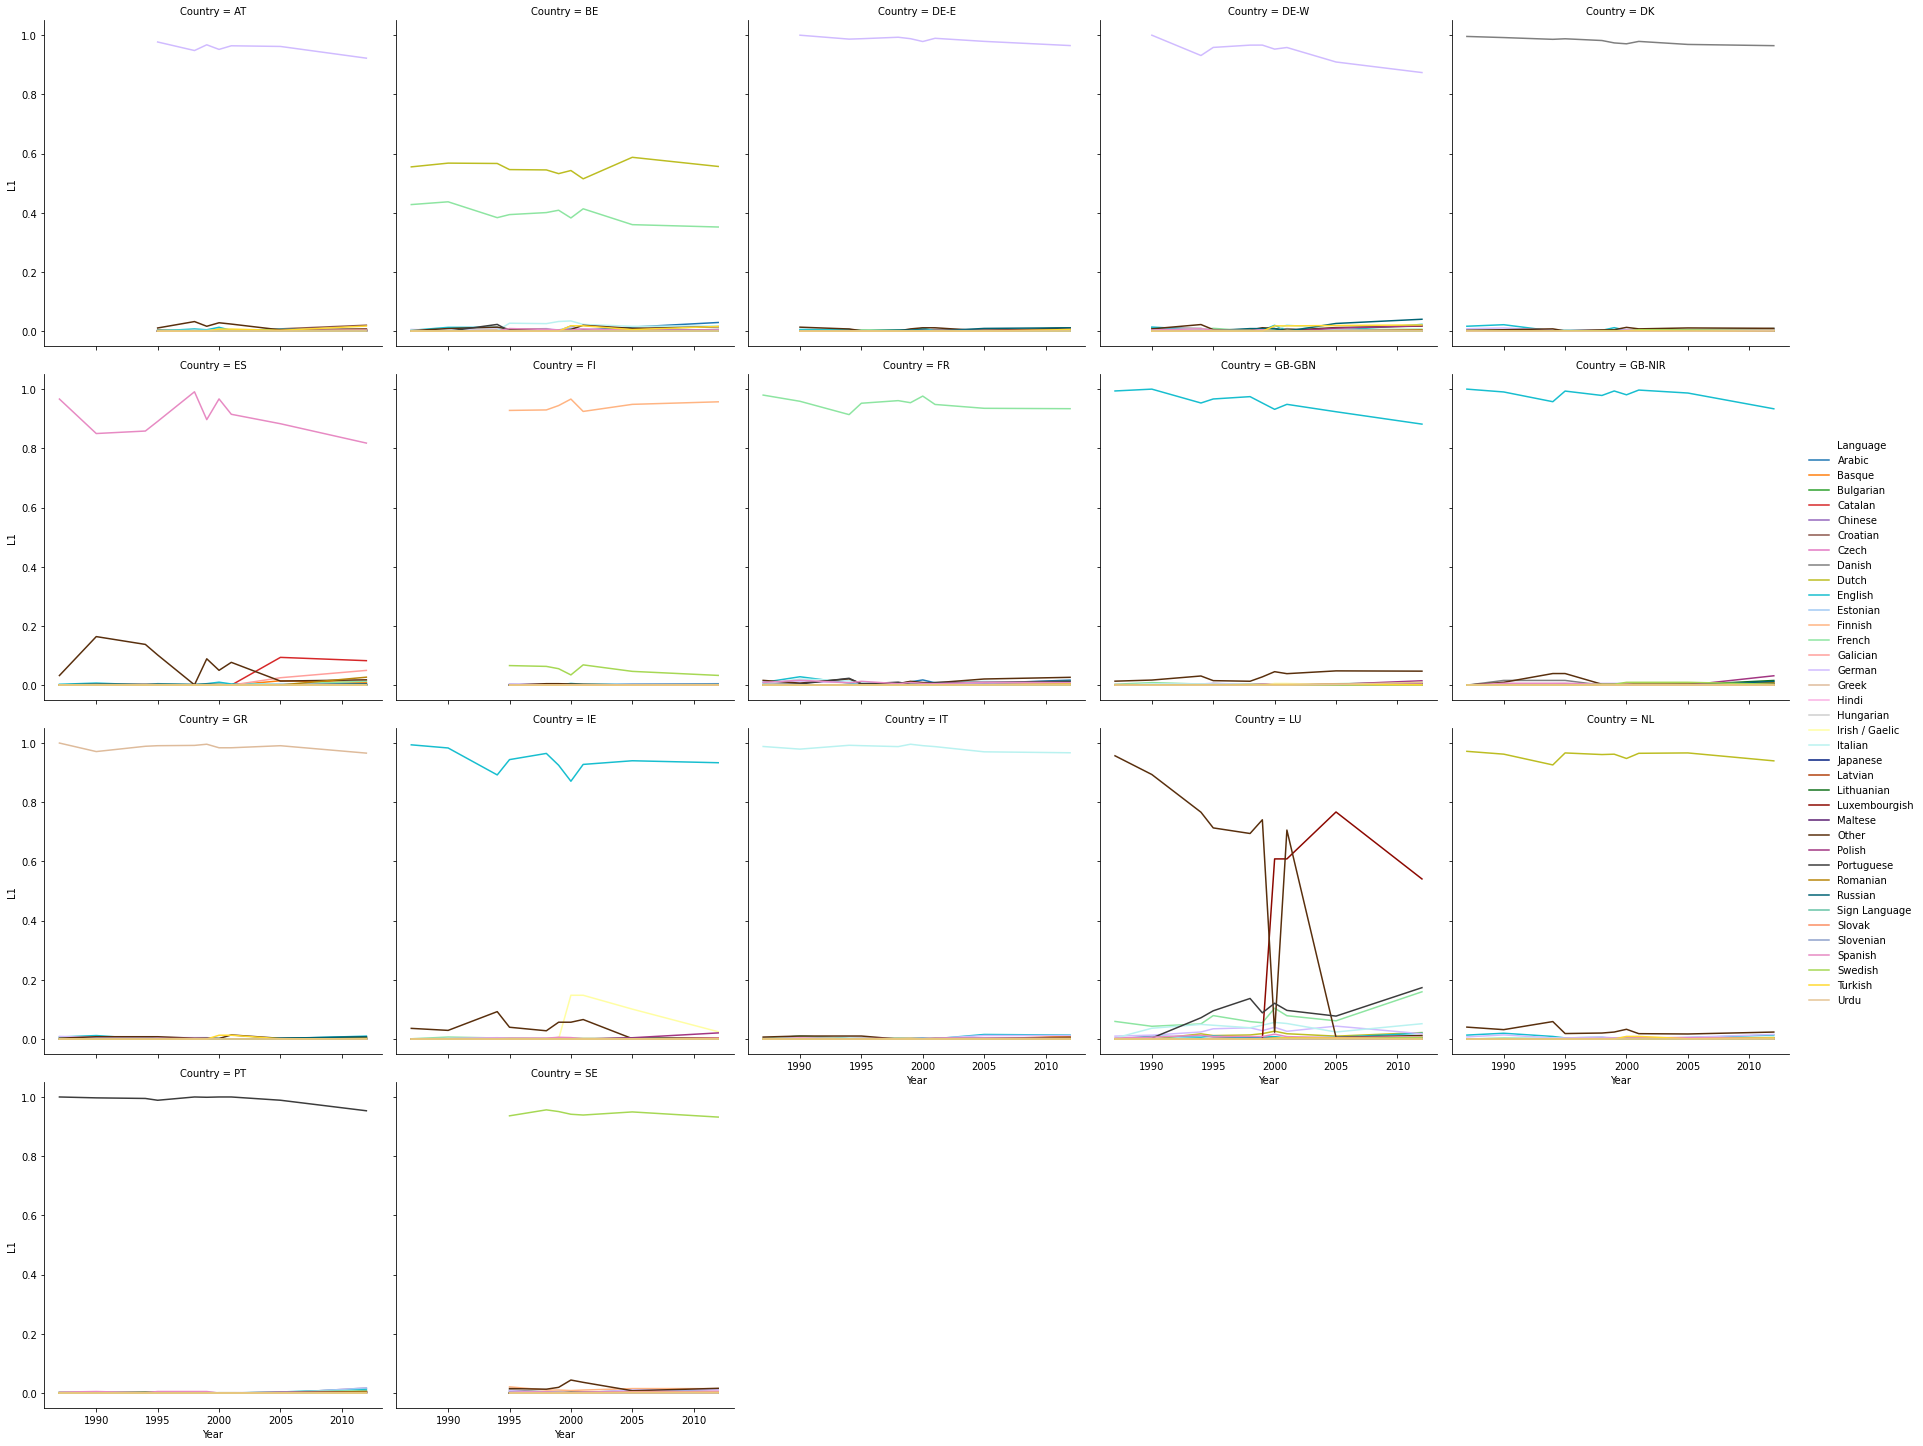

In [36]:
pal = sns.color_palette() + sns.color_palette('pastel') + sns.color_palette('dark') + sns.color_palette("Set2")
sns.relplot(
    data=agg_long,
    x="Year", y="L1",
    hue="Language", col='Country', col_wrap=5,
    kind="line", palette=pal[:len(agg_long.Language.unique())]
)

Without majority language(s):

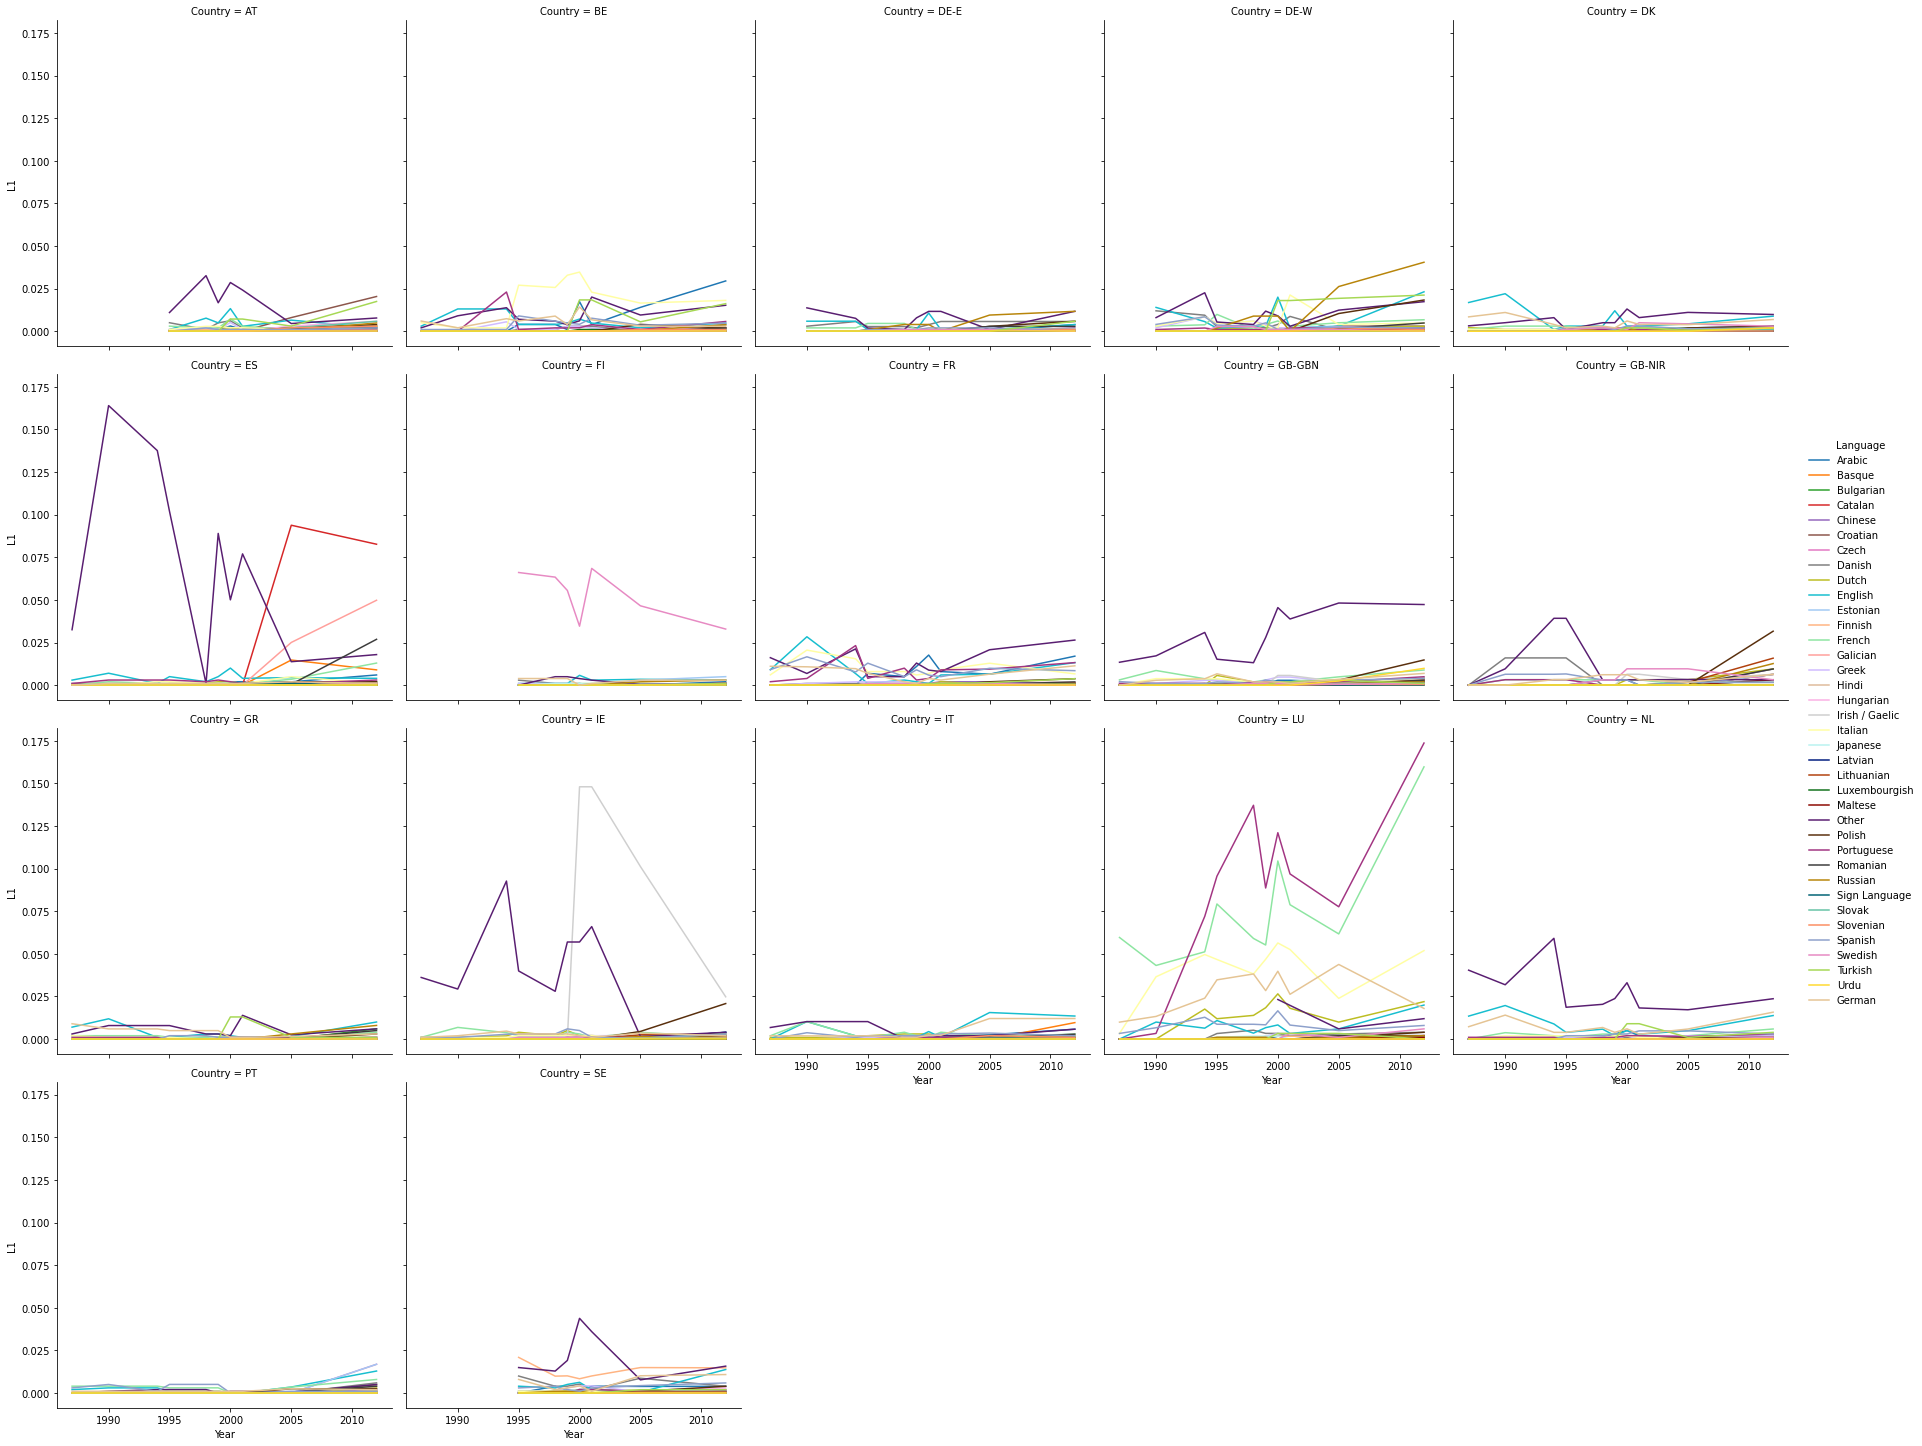

In [37]:
sns.relplot(
    data=agg_long[agg_long.L1 < 0.2],
    x="Year", y="L1",
    hue="Language", col='Country', col_wrap=5,
    kind="line", palette=pal[:len(agg_long.reset_index().Language.unique())]
)

Conclusion: Throughout Europe, most countries are becoming more multicultural. The proportion of the main language(s) in each country is on a downward trend in favour of a wide range of foreign languages. The only country unaffected by this appears to be Finland, where the proportion of Swedish speakers is falling in favour of Finnish.

#### L2 data

Which languages are most popular as foreign languages and in which countries?

In [38]:
m = agg_long.groupby(['Country', 'Language']).mean().reset_index()
top = m.groupby(['Country'])[['Language','L2']].apply(lambda x: x.nlargest(3, columns=['L2'])).reset_index()
vcs = top.Language.value_counts().to_frame()
vcs['Countries'] = vcs.apply(lambda x: " ".join(top[top.Language == x.name].Country),axis=1)
vcs

,Language,Countries
English,14,AT BE DE-E DE-W DK ES FI FR GR IT LU NL PT SE
French,14,AT BE DE-W DK ES GB-GBN GB-NIR GR IE IT LU NL ...
German,11,BE DE-W DK FI FR GB-GBN GB-NIR GR LU NL SE
Other,4,DE-E ES GB-NIR IE
Spanish,4,FR GB-GBN IT PT
Italian,1,AT
Russian,1,DE-E
Swedish,1,FI
Irish / Gaelic,1,IE


Conclusion: Unsurprisingly, English, French and German are the most popular foreign languages in the EU. Between countries, the proportion of people learning foreign languages varies widly. Unfortunately, it is hard to make out a trend over time based on this data, which is why I left out the corresponding plot. It can be found here: https://github.com/e8725144/lang-changes/blob/main/notebooks/Evelyn/eurobarometer_step3.ipynb

## Question 2: How does the number of speakers of certain languages change over time?

(Evelyn Birnzain)

### Load and clean up population data

In [39]:
data = pd.read_csv(pop_dir + 'demo_pjangroup__custom_1879586_page_tabular.tsv', sep='\t', na_values=[': ', ':'])
data.head()

,"freq,unit,sex,age,geo\TIME_PERIOD",1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,"A,NR,T,TOTAL,AD",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,78115,76246.0,NaN,NaN,NaN,NaN,NaN,76177,NaN,NaN
1,"A,NR,T,TOTAL,AL",1583800.0,1633800.0,1685800.0,1736838.0,1788404.0,1839866.0,1889715.0,1939430.0,1991765.0,...,2903008,2897770.0,2892394,2885796,2875592,2876591,2870324,2862427,2845955,2829741
2,"A,NR,T,TOTAL,AM",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3274285,NaN,NaN,3010598,2998577,2986151,2972732,2965269,2959694,2963251
3,"A,NR,T,TOTAL,AT",7030385.0,7064693.0,7107904.0,7151824.0,7199798.0,7247804.0,7293973.0,7350159.0,7403837.0,...,8408121,8451860.0,8507786,8584926,8700471,8772865,8822267,8858775,8901064,8932664
4,"A,NR,T,TOTAL,AZ",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9235085,9356483.0,9477119,9593038,9705643,9809981,9898085,9981457,10067108,10119133


In [40]:
data.iloc[:, 0] = data.iloc[:, 0].apply(lambda x: x.split(',')[-1])
data = data.rename({'freq,unit,sex,age,geo\TIME_PERIOD': 'Country'}, axis=1).set_index('Country')
data = data.replace("[^0-9.]", "", regex=True)
data = data.apply(pd.to_numeric)
data.head()

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
Country,,,,,,,,,,,,,,,,,,,,,
AD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,78115.0,76246.0,NaN,NaN,NaN,NaN,NaN,76177.0,NaN,NaN
AL,1583800.0,1633800.0,1685800.0,1736838.0,1788404.0,1839866.0,1889715.0,1939430.0,1991765.0,2052778.0,...,2903008.0,2897770.0,2892394.0,2885796.0,2875592.0,2876591.0,2870324.0,2862427.0,2845955.0,2829741.0
AM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3274285.0,NaN,NaN,3010598.0,2998577.0,2986151.0,2972732.0,2965269.0,2959694.0,2963251.0
AT,7030385.0,7064693.0,7107904.0,7151824.0,7199798.0,7247804.0,7293973.0,7350159.0,7403837.0,7426968.0,...,8408121.0,8451860.0,8507786.0,8584926.0,8700471.0,8772865.0,8822267.0,8858775.0,8901064.0,8932664.0
AZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9235085.0,9356483.0,9477119.0,9593038.0,9705643.0,9809981.0,9898085.0,9981457.0,10067108.0,10119133.0


### Prepare language and population datasets for joining

In [41]:
ldata = agg

# Find countries that appear in the language data that we don't have population data for
ldata_c = set(ldata.reset_index().Country)
popdata_c = set(data.reset_index().Country)
ldata_c - popdata_c

{'CY-TCC', 'DE-E', 'DE-W', 'GB-GBN', 'GB-NIR', 'GR'}

#### Language data

Reasoning on why different countries are treated as they are in the following, see: https://github.com/Eszti/lang-changes/blob/main/notebooks/Evelyn/eurobarometer_step3.ipynb 

In [42]:
def combine_countries(ldata, country1, country2, new_name):
    tot = (ldata.loc[country1] + ldata.loc[country2])/2
    tot['Country'] = new_name
    tot = tot.reset_index().set_index(['Country', 'Year'])
    ldata = ldata.drop([country1, country2, new_name], errors='ignore')
    ldata = ldata.append(tot).sort_index()
    return ldata

ldata = ldata.drop('GR')
ldata = ldata.rename(index={'CY-TCC': 'CY'})
ldata = combine_countries(ldata, 'DE-E', 'DE-W', 'DE')
ldata = combine_countries(ldata, 'GB-GBN', 'GB-NIR', 'UK')

#### Population data

In [43]:
data = data.rename(index={'DE': 'BRD', 'DE_TOT': 'DE'})

Interpolate missing data for easier handling later.

In [44]:
data = data.interpolate(method = 'linear', limit_direction = 'both', axis=1)
data.head()

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
Country,,,,,,,,,,,,,,,,,,,,,
AD,44593.0,44593.0,44593.0,44593.0,44593.0,44593.0,44593.0,44593.0,44593.0,44593.0,...,78115.0,7.624600e+04,7.623450e+04,76223.0,76211.5,76200.0,76188.5,76177.0,76177.0,76177.0
AL,1583800.0,1633800.0,1685800.0,1736838.0,1788404.0,1839866.0,1889715.0,1939430.0,1991765.0,2052778.0,...,2903008.0,2.897770e+06,2.892394e+06,2885796.0,2875592.0,2876591.0,2870324.0,2862427.0,2845955.0,2829741.0
AM,3226900.0,3226900.0,3226900.0,3226900.0,3226900.0,3226900.0,3226900.0,3226900.0,3226900.0,3226900.0,...,3274285.0,3.186389e+06,3.098494e+06,3010598.0,2998577.0,2986151.0,2972732.0,2965269.0,2959694.0,2963251.0
AT,7030385.0,7064693.0,7107904.0,7151824.0,7199798.0,7247804.0,7293973.0,7350159.0,7403837.0,7426968.0,...,8408121.0,8.451860e+06,8.507786e+06,8584926.0,8700471.0,8772865.0,8822267.0,8858775.0,8901064.0,8932664.0
AZ,8016200.0,8016200.0,8016200.0,8016200.0,8016200.0,8016200.0,8016200.0,8016200.0,8016200.0,8016200.0,...,9235085.0,9.356483e+06,9.477119e+06,9593038.0,9705643.0,9809981.0,9898085.0,9981457.0,10067108.0,10119133.0


Bring into long form for easy joining.

In [45]:
pop_data_l = pd.melt(data.reset_index(), id_vars='Country', var_name='Year', value_name='pop')
pop_data_l['Year'] = pop_data_l['Year'].astype('int64')
pop_data_l = pop_data_l.set_index(['Country', 'Year'])
pop_data_l.head()

,,pop
Country,Year,
AD,1960,44593.0
AL,1960,1583800.0
AM,1960,3226900.0
AT,1960,7030385.0
AZ,1960,8016200.0


Check population data for plausibility.

Text(0.5, 1.0, 'Population growth Germany')

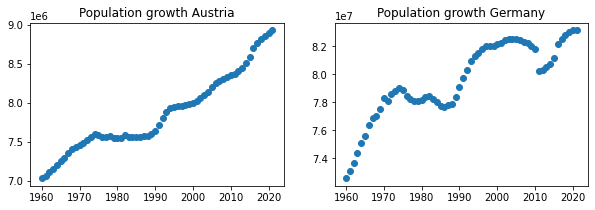

In [46]:
fig, axes = plt.subplots(1,2, figsize=(10,3))
s = pop_data_l.loc['AT']
axes[0].scatter(s.index, s.values)
axes[0].set_title('Population growth Austria')
s = pop_data_l.loc['DE']
axes[1].scatter(s.index, s.values)
axes[1].set_title('Population growth Germany')

### Join language and population datasets

Match language and population data per country and year.

In [47]:
ldata = ldata.join(pop_data_l)
ldata.head()

L1_Danish  L1_German  L1_French  L1_Italian  L1_Dutch  \
Country Year                                                          
AT      1995   0.004985   0.977069   0.002991    0.000997  0.000000   
        1998   0.000959   0.948226   0.001918    0.002876  0.000000   
        1999   0.004912   0.967583   0.000000    0.000000  0.001965   
        2000   0.006122   0.952041   0.007143    0.002041  0.000000   
        2001   0.001932   0.964251   0.002899    0.000000  0.000966   

              L1_English  L1_Spanish  L1_Portuguese  L1_Greek  L1_Other  ...  \
Country Year                                                             ...   
AT      1995    0.000997    0.000000            0.0  0.000997  0.010967  ...   
        1998    0.007670    0.001918            0.0  0.001918  0.032598  ...   
        1999    0.004912    0.000982            0.0  0.000982  0.016699  ...   
        2000    0.013265    0.000000            0.0  0.005102  0.028571  ...   
        2001    0.002899    0.000966            0.0  0.000966  0.024155  ...   

              L2_Romanian  L2_Slovak  L2_Slovenian  L1_Galician  L1_Hindi  \
Country Year                                                                
AT      1995          0.0        0.0           0.0          0.0       0.0   
        1998          0.0        0.0           0.0          0.0       0.0   
        1999          0.0        0.0           0.0          0.0       0.0   
        2000          0.0        0.0           0.0          0.0       0.0   
        2001          0.0        0.0           0.0          0.0       0.0   

              L1_Urdu  L2_Galician  L2_Hindi  L2_Urdu        pop  
Country Year                                                      
AT      1995      0.0          0.0       0.0      0.0  7943489.0  
        1998      0.0          0.0       0.0      0.0  7971116.0  
        1999      0.0          0.0       0.0      0.0  7982461.0  
        2000      0.0          0.0       0.0      0.0  8002186.0  
        2001      0.0          0.0       0.0      0.0  8020946.0  

[5 rows x 75 columns]

Multiply the fractions of each language in a country for a given year with the corresponding population numbers to get an estimate of absolute speaker numbers. Interpolate missing data over a maximum of two consecutive points in time.

In [48]:
abs_speakers = ldata.apply(lambda x: x * ldata['pop']).drop('pop', axis=1)
abs_speakers = abs_speakers.astype(int)
abs_speakers = abs_speakers.replace(0, np.NaN).groupby('Country').apply(lambda x: x.interpolate(method = 'linear', limit_direction = 'both', limit=2))
abs_speakers.head()

L1_Danish  L1_German  L1_French  L1_Italian  L1_Dutch  \
Country Year                                                          
AT      1995    39598.0  7761335.0    23759.0      7919.0   15682.0   
        1998     7642.0  7558421.0    15284.0     22927.0   15682.0   
        1999    39206.0  7723697.0    36221.0     19628.5   15682.0   
        2000    48992.0  7618407.0    57158.0     16330.0   11715.5   
        2001    15499.0  7734206.0    23249.0     12263.5    7749.0   

              L1_English  L1_Spanish  L1_Portuguese  L1_Greek  L1_Other  ...  \
Country Year                                                             ...   
AT      1995      7919.0     15284.0            NaN    7919.0   87117.0  ...   
        1998     61139.0     15284.0            NaN   15284.0  259844.0  ...   
        1999     39206.0      7841.0            NaN    7841.0  133302.0  ...   
        2000    106151.0      7795.0         4098.0   40827.0  228633.0  ...   
        2001     23249.0      7749.0         4098.0    7749.0  193742.0  ...   

              L2_Polish  L2_Romanian  L2_Slovak  L2_Slovenian  L1_Galician  \
Country Year                                                                 
AT      1995        NaN          NaN        NaN           NaN          NaN   
        1998        NaN          NaN        NaN           NaN          NaN   
        1999        NaN          NaN        NaN           NaN          NaN   
        2000    24591.0      20493.0    16394.0      110663.0          NaN   
        2001    24591.0      20493.0    16394.0      110663.0       8155.0   

              L1_Hindi  L1_Urdu  L2_Galician  L2_Hindi  L2_Urdu  
Country Year                                                     
AT      1995       NaN      NaN          NaN       NaN      NaN  
        1998       NaN      NaN          NaN       NaN      NaN  
        1999       NaN      NaN          NaN       NaN      NaN  
        2000       NaN      NaN          NaN       NaN      NaN  
        2001    8155.0      NaN          NaN       NaN      NaN  

[5 rows x 74 columns]

### Visualization

Bring data into long form for plotting.

In [49]:
agg_long = ldata_wide_to_long(abs_speakers).drop('index', axis=1)
agg_long = agg_long.replace(0, np.NaN)

#### Absolute number of speakers by country over time

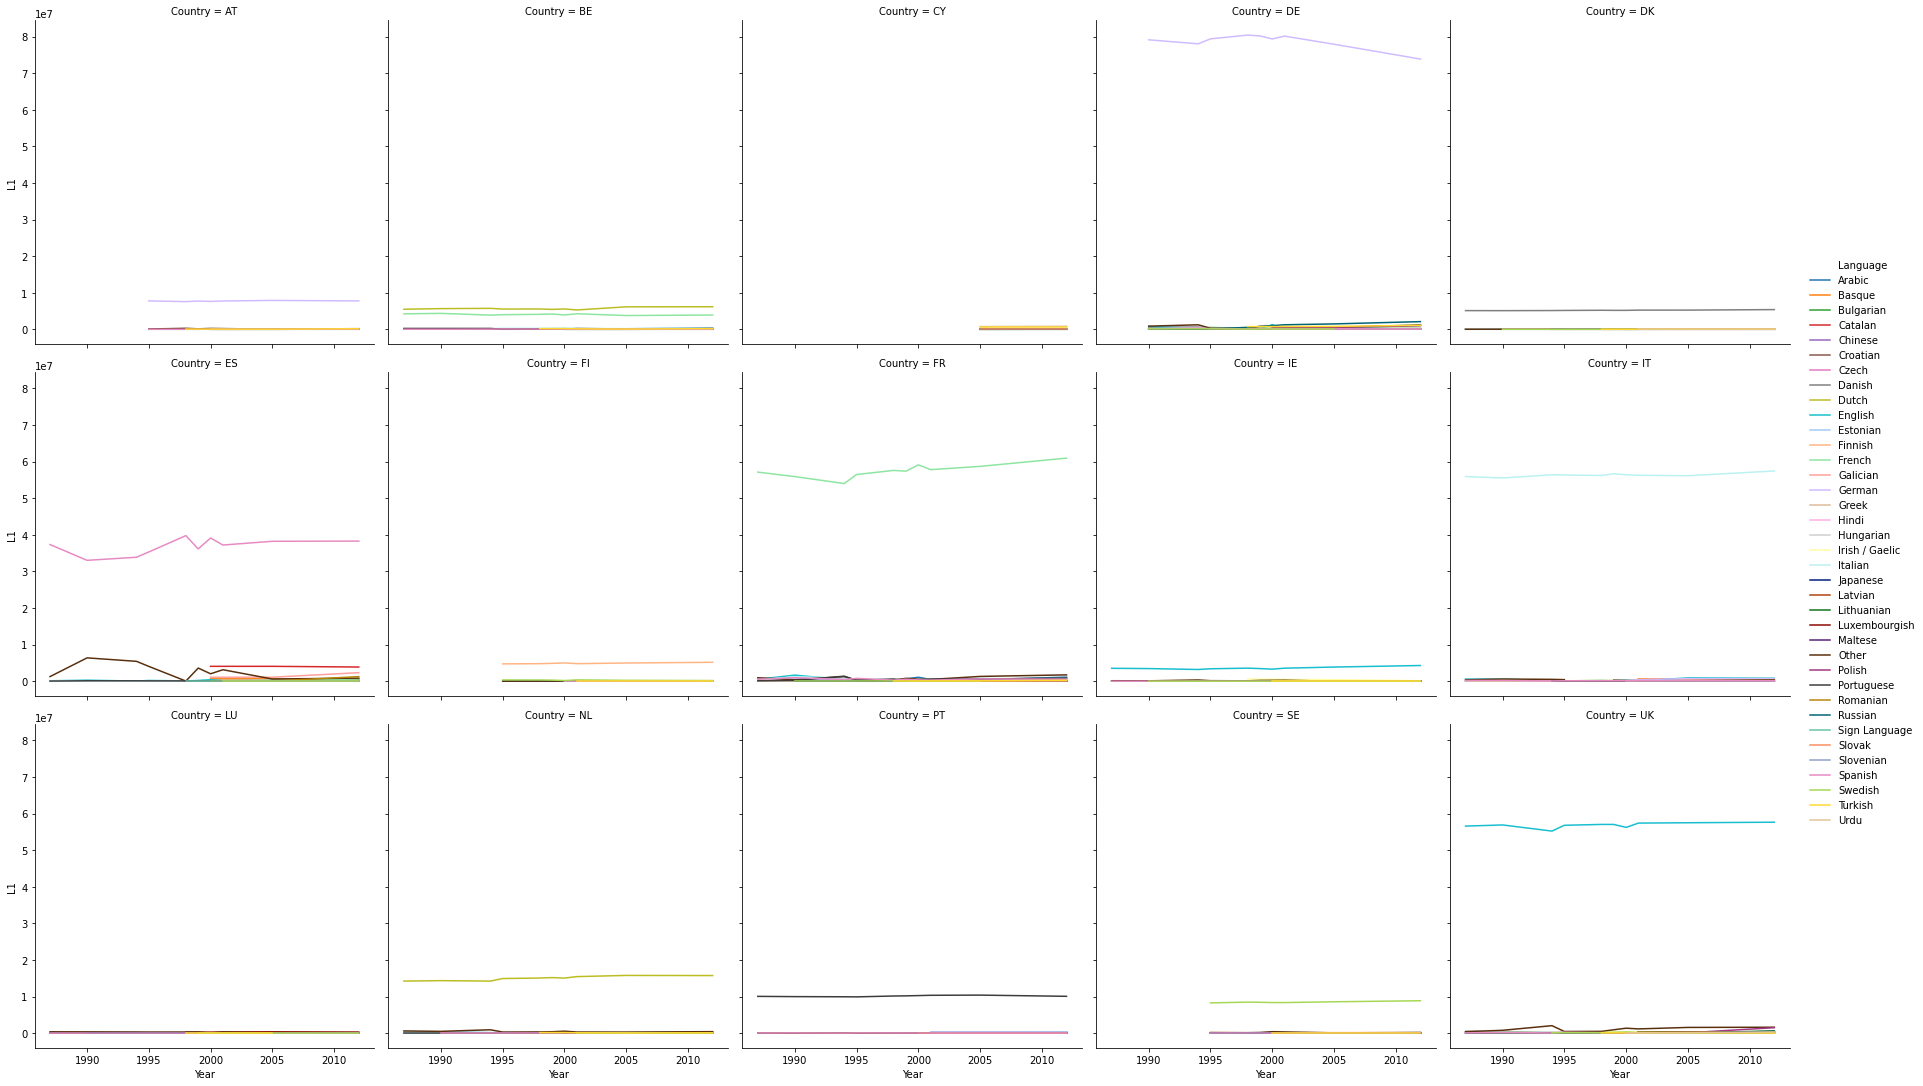

In [50]:
sns.relplot(
    data=agg_long,
    x="Year", y="L1",
    hue="Language", col='Country', col_wrap=5,
    kind="line", palette=pal[:len(agg_long.Language.unique())]
)

#### Absolute number of speaker over time - aggegrated

Sum up number of speakers of a language over all countries. Take only languages for which we have a decent amount of data points.

In [51]:
agg = agg_long.groupby(['Language', 'Year']).sum()
agg = agg.replace(0, np.NaN)

s = agg.reset_index().groupby('Language').count().L1
ls = s[s > 5].index
print(list(ls))
agg = agg.loc[ls]
agg = agg.reset_index()

['Arabic', 'Chinese', 'Danish', 'Dutch', 'English', 'Finnish', 'French', 'German', 'Greek', 'Irish / Gaelic', 'Italian', 'Japanese', 'Luxembourgish', 'Other', 'Portuguese', 'Russian', 'Spanish', 'Swedish', 'Turkish']


<AxesSubplot:xlabel='Year', ylabel='L1'>

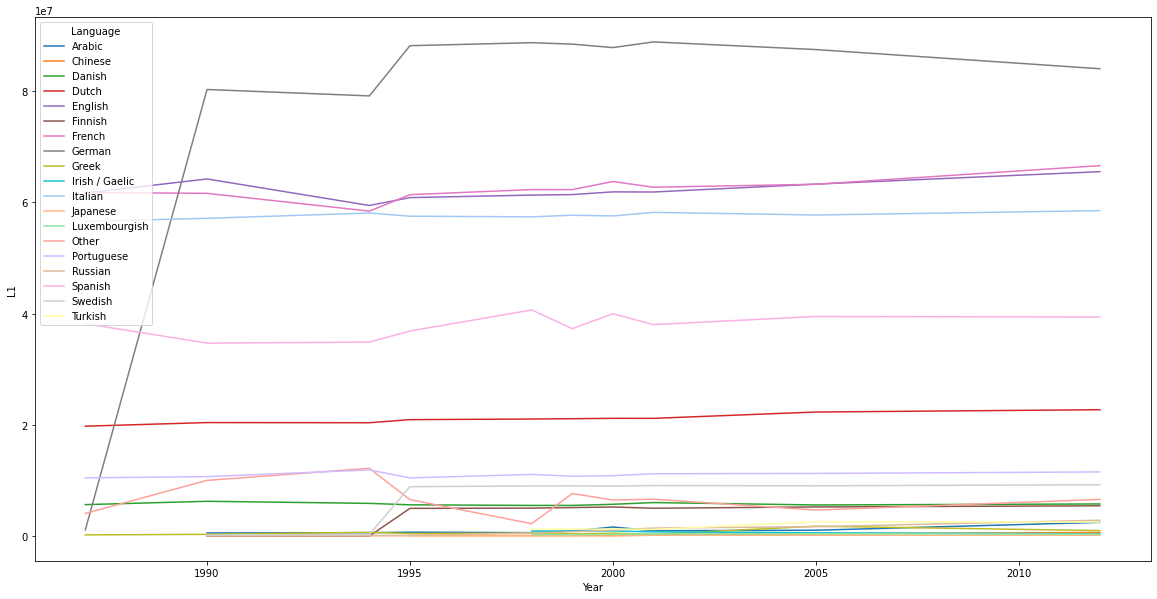

In [52]:
plt.figure(figsize=(20,10))
sns.lineplot(
    data=agg,
    x="Year", y="L1",
    hue="Language",
    palette=pal[:len(agg.Language.unique())]
)

Regarding the jumps for German:
* 1990: Reunification of Germany, start of language data for reunified Germany.
* 1995: Austria joins the EU, start of language data for Austria.

Conclusion: The absolute number of speakers for all major languages appears to be rising even though the proportion of these languages in each country is falling. The only exception is German, whose speaker numbers seem to be falling since around 2001.

#### Relative number of speakers over time - aggegrated

Divide absolute speaker numbers by maximum for each language in order to normalise to [0,1] and get an idea of trends and how fast a language is growing/shrinking in comparison.

In [53]:
def normalise(agg, key):
    other = 'L2' if key == 'L1' else 'L1'
    max_per_lang = agg.groupby('Language').max()[key].to_frame().reset_index().rename({key: 'Max'}, axis=1)
    m = pd.merge(agg, max_per_lang, on='Language').drop(other, axis=1).set_index(['Language', 'Year'])
    m = m.apply(lambda x: x / m['Max']).drop('Max', axis=1).reset_index()
    return m

m = normalise(agg, 'L1')

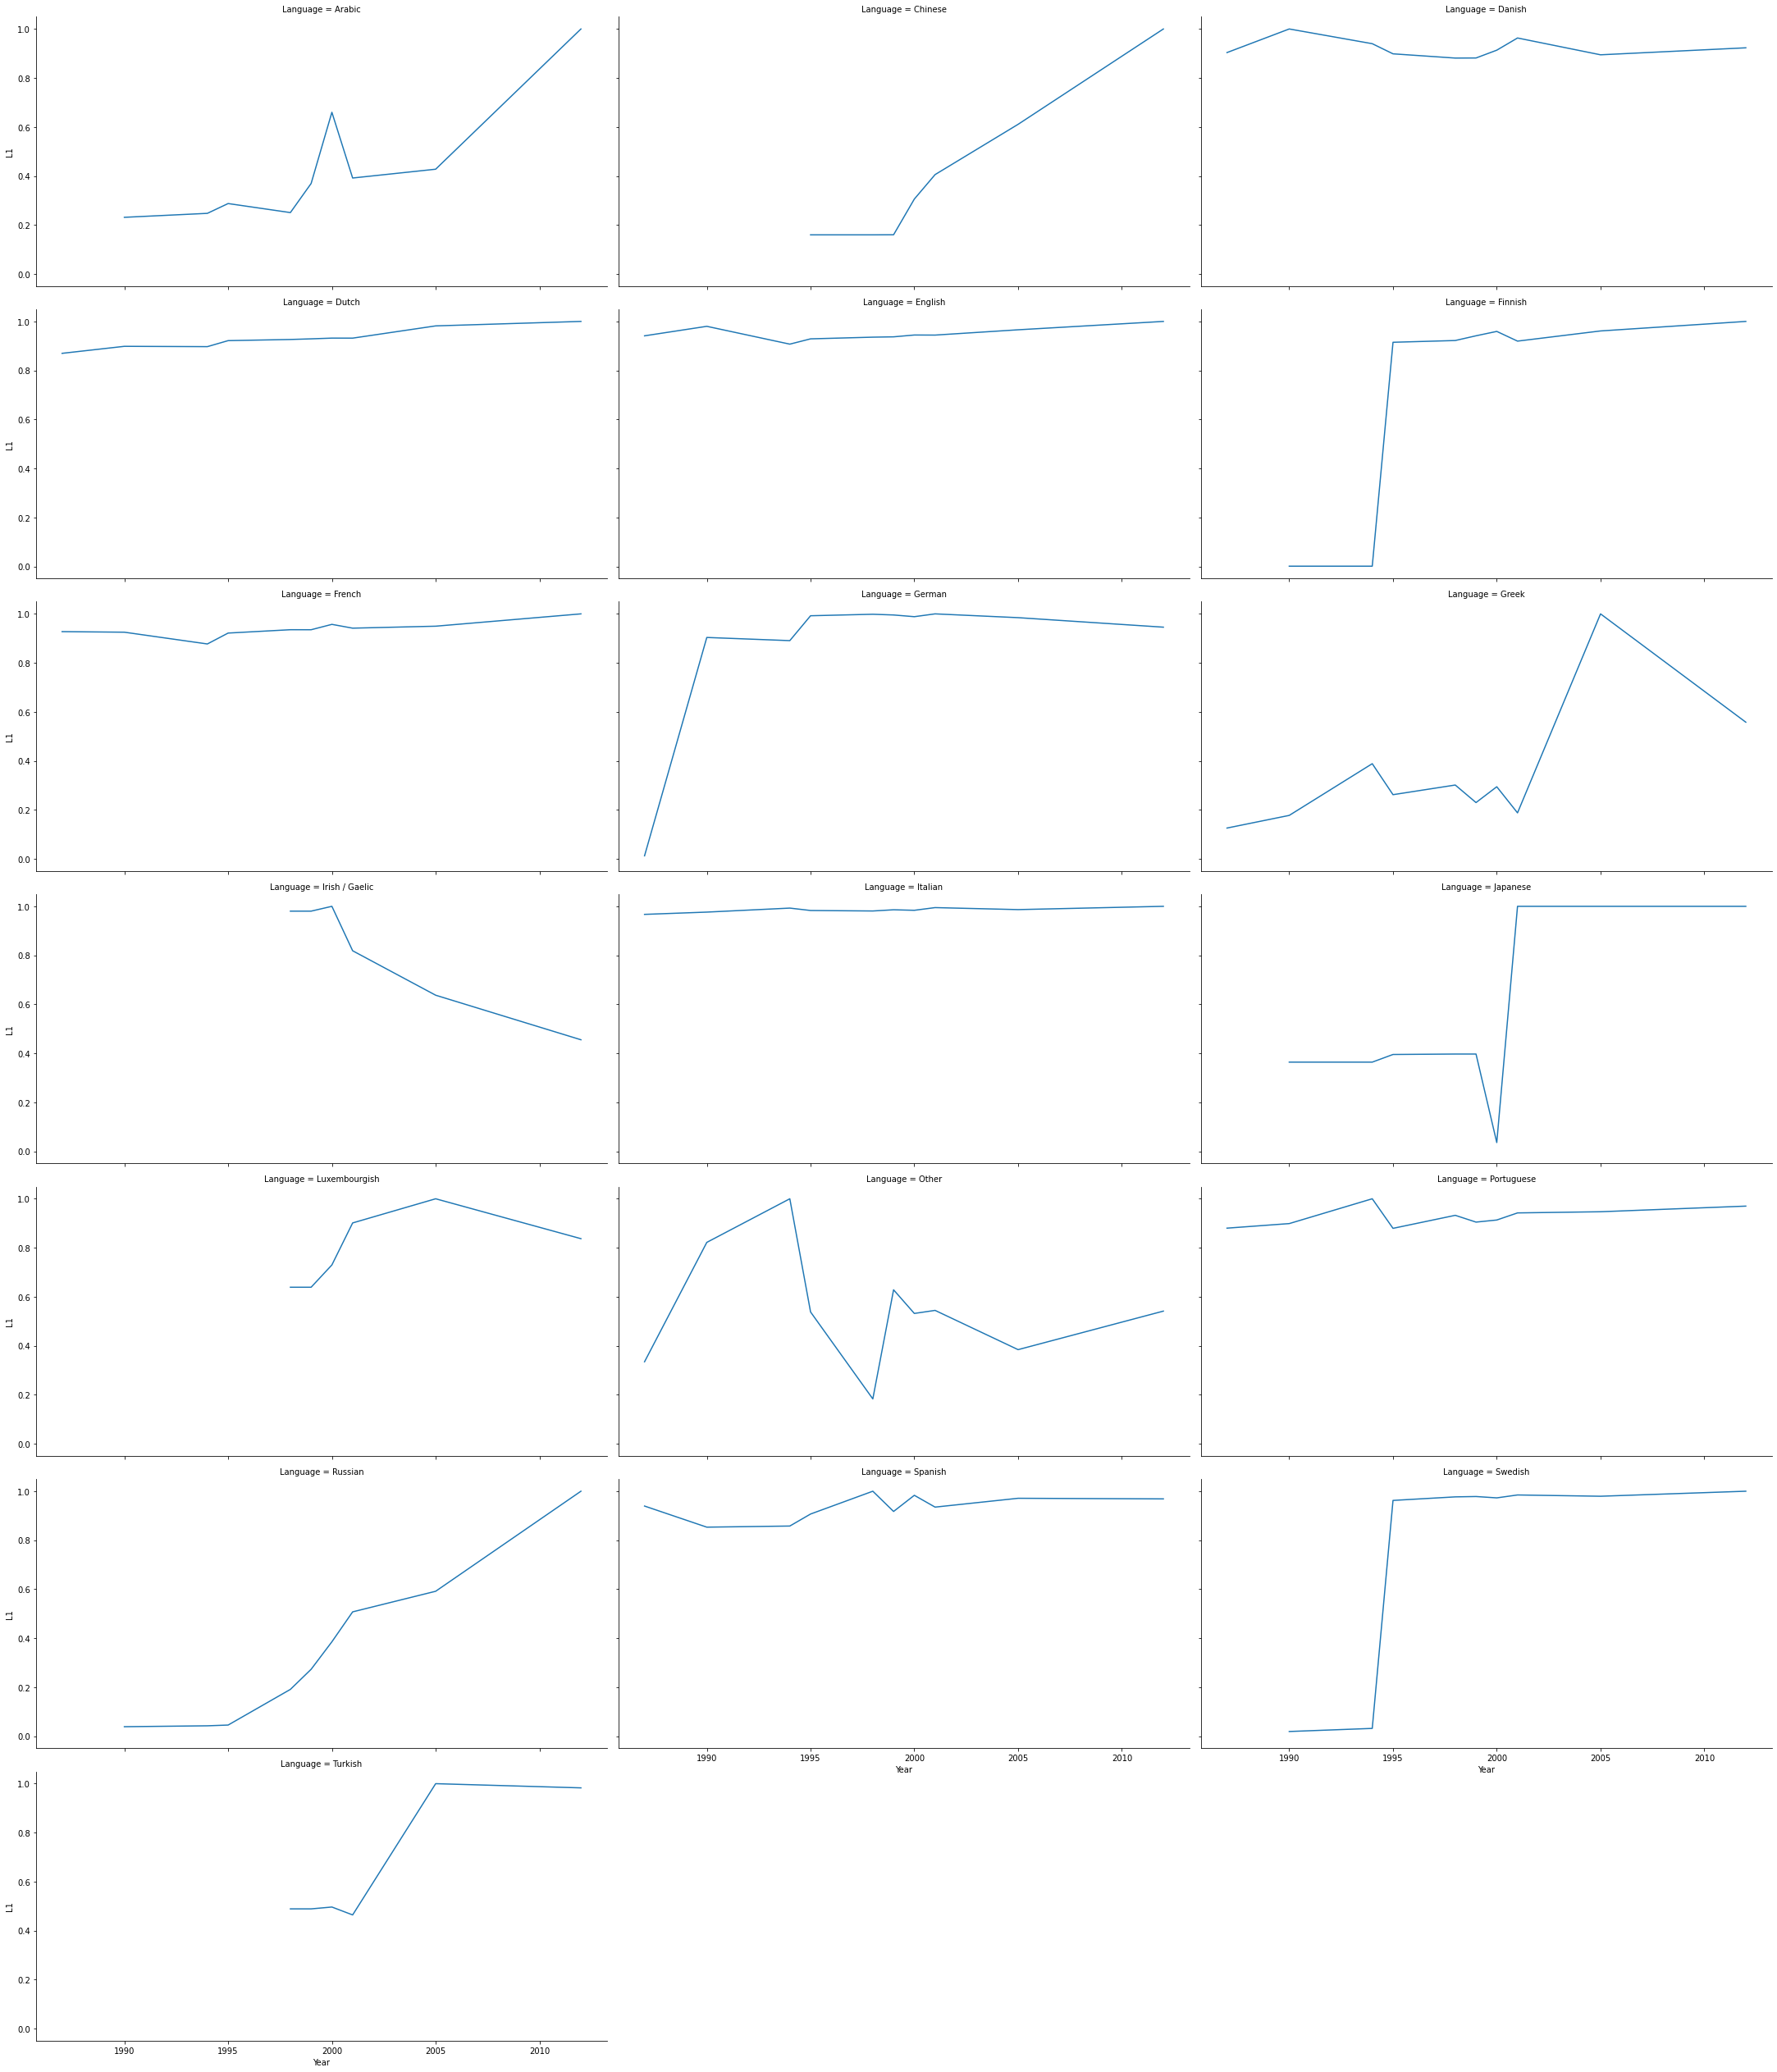

In [54]:
sns.relplot(
    data=m,
    x="Year", y="L1",
    col='Language', col_wrap=3, aspect=2, #facet_kws={'sharey':False},
    kind="line", palette=pal[:len(m.Language.unique())]
)

Conclusion: The major languages are mostly rising steadily, while there has been a major influx of Arabic, Chinese, Turkish and Russian speakers. Irish/Gaelic on the other hand is disappearing fast as a native language.